## Project. Data analysis using YouTube trend statistics as an example. Made by - Slavnyi Bogdan

## Introduction

This is a real dataset. Compiled by one of the users of the Kaggle site using a bot.
Link to the dataset on the Kaggle site https://www.kaggle.com/datasnaek/youtube-new

After reviewing dozens of works by other members of the Kaggle site, I did not find a single report that also found duplicates in this dataset. Duplicates can quite significantly distort the data, and therefore affect the decisions made, not for the better.

Before proceeding with the processing of the dataset, we first analyze the problem in general.
There is a "Trends" tab on YouTube. Mostly "viral" videos get there - those that are rapidly gaining popularity. The YouTube algorithm, based on a huge number of factors, decides which video will fall into trends and which will not. These factors can be - an increase in the number of views, likes, reposts, the activity of comments ... Moreover, YouTube allocates daily video quotas for each country.
The task is to process the dataset (put files - json, csv into one table), bring the data to the desired form. Determine what factors are decisive when a video hits trends. Answer questions that allow you to look at the data from different angles.

**I can also generate the same report in German.**

## Contents (links are clickable for faster project navigation)

1. [Loading, merging, processing, exporting data](#1.)
2. [Remove Duplicates](#2.)
    2.1 [Description of the problem with duplicates](#2.1)
    
    2.2 [Solving the problem with duplicates and undefined video_id](#2.2)
    2.2.1 [Dealing with undefined video_id](#2.2.1)
    2.2.2 [Solve the problem with duplicate lines](#2.2.2)
    2.2.3 [Checking the result of our work for duplicates](#2.2.3)
        
        
3. [Answers to questions from marketing staff](#3.)
    3.1 [What factors affect video trending](#3.1)
    3.2 [What are the taste preferences of people from different countries?](#3.2)
    3.3 [How the taste preferences of Russians and residents of other countries differ (on average)](#3.3)
    3.4 [Is it true that Indians and Germans watch the same thing?](#3.4)
    3.5 [View/like/dislike ratio for different categories.](#3.5)
    3.6 [Which categories are the most viewed on YouTube?](#3.6)
    3.7 [How many views do videos get relative to each category by median?](#3.7)
    
    3.8 [Seasonality of trends in Britain.](#3.8)
    3.8.1 [Why did the 'Music' category start trending up in the UK? Generate a hypothesis](#3.8.1)
    
    3.9 [Youtube's Daily Trending Quotas for Countries](#3.9)
    3.10 [How quickly do videos trend on average after release?](#3.10)
    3.11 [Why is the same video trending in the UK twice as long as trending in the US?](#3.11)
    
    3.12 [Find news stories that influenced YouTube trends](#3.12)
    3.12.1 [Information about the death of Crannberies lead singer Dolores Mary Eileen O'Riordan](#3.12.1)
    3.12.2 [Information about the sex scandal of actress Salma Hayek and American film producer Harvey Weinstein](#3.12.2)

In [37]:
df_no_duplicates.head(2)

video_id        trending_date  \
0  --1skHapGUc  2018-02-10 00:00:00   
1  --2K8l6BWfw  2018-03-06 00:00:00   

                                               title  channel_title  \
0  SI TE RÍES, PIERDES (NIVEL ASIÁTICO) #51 Los M...   TheChacal547   
1                   La Relève #2 : Jessica Rodrigues  Georgette Mag   

                                                tags  views  likes  dislikes  \
0  Videos de Risa|"Si te ries pierdes"|"videos gr...  30914    483        77   
1  Jessica Rodrigues"|"jumping"|"horse"|"cheval"|...   4822    694         4   

   comment_count                                  thumbnail_link  ...  \
0             81  https://i.ytimg.com/vi/--1skHapGUc/default.jpg  ...   
1             34  https://i.ytimg.com/vi/--2K8l6BWfw/default.jpg  ...   

   ratings_disabled  video_error_or_removed  \
0                 0                       0   
1                 0                       0   

                                         description        category  \
0  Video para partirse de risa! pero cuidado, int...   Entertainment   
1  Retrouve-nous sur ➼ http://www.georgettemag.co...  Pets & Animals   

    publish_time_no_tz   publish_date_no_tz Country points  Year_month_int  \
0  2018-02-09 19:04:43  2018-02-09 00:00:00  Mexico      1          201802   
1  2018-03-05 13:37:34  2018-03-05 00:00:00  France      1          201803   

   days_since_publish  
0                   1  
1                   1  

[2 rows x 21 columns]

## 1. Loading, combining, processing, exporting data
<a id="1."></a>

As you know, in practice, the primary collection and processing of data takes up to **80%** of working time. This process is very responsible, because further reports will be built on the basis of the final structure. One of the main goals before embarking on transformation is to understand what they are in general. How they were going to, what are the limitations and what generally useful can be "blinded" from them. Is there enough data, if not, which ones are missing. And, if you get them, how much will the model improve.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
%matplotlib inline
from PIL import Image

In [3]:
# For a faster call to the autocomplete function by pressing TAB
%config Completer.use_jedi = False

In [3]:
from glob import glob

stock_files_csv = sorted(glob('data/*videos.csv'))
stock_files_json = sorted(glob('data/*_category_id.json'))

print('Количество csv файлов: ', len(stock_files_csv), '\n', stock_files_csv,'\n\n', \
      'Количество json файлов: ', len(stock_files_json), '\n', stock_files_json)

Количество csv файлов:  10 
 ['data\\CAvideos.csv', 'data\\DEvideos.csv', 'data\\FRvideos.csv', 'data\\GBvideos.csv', 'data\\INvideos.csv', 'data\\JPvideos.csv', 'data\\KRvideos.csv', 'data\\MXvideos.csv', 'data\\RUvideos.csv', 'data\\USvideos.csv'] 

 Количество json файлов:  10 
 ['data\\CA_category_id.json', 'data\\DE_category_id.json', 'data\\FR_category_id.json', 'data\\GB_category_id.json', 'data\\IN_category_id.json', 'data\\JP_category_id.json', 'data\\KR_category_id.json', 'data\\MX_category_id.json', 'data\\RU_category_id.json', 'data\\US_category_id.json']


In [4]:
# Loop through all the json files and put them in a dictionary.
# The dictionary contains only unique keys, if the keys match, the '.update' function replaces it with a new one.
# This will eliminate the risk that if some of the json files do not contain all the categories, then they will be added from other files.
category_dict = {}


for file_json in stock_files_json:
    
    with open(file_json) as access_json:
        read_content = json.load(access_json)

        for i in read_content['items']:
            category_dict.update({i['id']: i['snippet']['title']})

print(category_dict)

{'1': 'Film & Animation', '2': 'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17': 'Sports', '18': 'Short Movies', '19': 'Travel & Events', '20': 'Gaming', '21': 'Videoblogging', '22': 'People & Blogs', '23': 'Comedy', '24': 'Entertainment', '25': 'News & Politics', '26': 'Howto & Style', '27': 'Education', '28': 'Science & Technology', '30': 'Movies', '31': 'Anime/Animation', '32': 'Action/Adventure', '33': 'Classics', '34': 'Comedy', '35': 'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39': 'Horror', '40': 'Sci-Fi/Fantasy', '41': 'Thriller', '42': 'Shorts', '43': 'Shows', '44': 'Trailers', '29': 'Nonprofits & Activism'}


In [5]:
"""Let's convert the dictionary containing the categories into a Pandas DataFrame. In order to later connect it to the main table,
containing browsing data using a Pandas function similar to INNER JOIN.
"""

category_dict_pandas = pd.DataFrame(category_dict.items(), columns=['category_id', 'category'])
category_dict_pandas.head()

category_id          category
0           1  Film & Animation
1           2  Autos & Vehicles
2          10             Music
3          15    Pets & Animals
4          17            Sports

In [6]:
print(stock_files_csv)

['data\\CAvideos.csv', 'data\\DEvideos.csv', 'data\\FRvideos.csv', 'data\\GBvideos.csv', 'data\\INvideos.csv', 'data\\JPvideos.csv', 'data\\KRvideos.csv', 'data\\MXvideos.csv', 'data\\RUvideos.csv', 'data\\USvideos.csv']


In [7]:
# Combine csv files of different countries into one table
df = pd.concat((pd.read_csv(file).assign(filename=file) \
          for file in stock_files_csv), ignore_index=True)

In [8]:
df.head(3)

video_id trending_date  \
0  n1WpP7iowLc      17.14.11   
1  0dBIkQ4Mz1M      17.14.11   
2  5qpjK5DgCt4      17.14.11   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   

   category_id              publish_time  \
0           10  2017-11-10T17:00:03.000Z   
1           23  2017-11-13T17:00:00.000Z   
2           23  2017-11-12T19:05:24.000Z   

                                                tags     views   likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  17158579  787425   
1  plush|"bad unboxing"|"unboxing"|"fan mail"|"id...   1014651  127794   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434  146035   

   dislikes  comment_count                                  thumbnail_link  \
0     43420         125882  https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg   
1      1688          13030  https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg   
2      5339           8181  https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   

                                         description           filename  
0  Eminem's new track Walk on Water ft. Beyoncé i...  data\CAvideos.csv  
1  STill got a lot of packages. Probably will las...  data\CAvideos.csv  
2  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...  data\CAvideos.csv

In [9]:
# Change the data type of 'category_id' from 'int' to 'str'
df['category_id'] = df['category_id'].astype('str')

In [10]:
# Append category names to our table
df = pd.merge(df, category_dict_pandas, on='category_id')

In [11]:
# Table contains 376000 rows and 18 columns (features)
df.shape

(375942, 18)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375942 entries, 0 to 375941
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   video_id                375942 non-null  object
 1   trending_date           375942 non-null  object
 2   title                   375942 non-null  object
 3   channel_title           375942 non-null  object
 4   category_id             375942 non-null  object
 5   publish_time            375942 non-null  object
 6   tags                    375942 non-null  object
 7   views                   375942 non-null  int64 
 8   likes                   375942 non-null  int64 
 9   dislikes                375942 non-null  int64 
 10  comment_count           375942 non-null  int64 
 11  thumbnail_link          375942 non-null  object
 12  comments_disabled       375942 non-null  bool  
 13  ratings_disabled        375942 non-null  bool  
 14  video_error_or_removed  375942 non-n

In [13]:
# Attach "20" to the beginning of each line of the 'trending_date' column
df['trending_date'] = '20' + df['trending_date']

In [14]:
df['trending_date'].head(2)

0    2017.14.11
1    2017.14.11
Name: trending_date, dtype: object

In [15]:
# Convert 'str' to 'datetime' format
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%Y.%d.%m')
df['trending_date'].head(2)

0   2017-11-14
1   2017-11-14
Name: trending_date, dtype: datetime64[ns]

In [16]:
df.head(2)

video_id trending_date                                        title  \
0  n1WpP7iowLc    2017-11-14   Eminem - Walk On Water (Audio) ft. Beyoncé   
1  2Vv-BfVoq4g    2017-11-14  Ed Sheeran - Perfect (Official Music Video)   

  channel_title category_id              publish_time  \
0    EminemVEVO          10  2017-11-10T17:00:03.000Z   
1    Ed Sheeran          10  2017-11-09T11:04:14.000Z   

                                                tags     views    likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  17158579   787425   
1  edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...  33523622  1634130   

   dislikes  comment_count                                  thumbnail_link  \
0     43420         125882  https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg   
1     21082          85067  https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   

                                         description           filename  \
0  Eminem's new track Walk on Water ft. Beyoncé i...  data\CAvideos.csv   
1  🎧: https://ad.gt/yt-perfect\n💰: https://atlant...  data\CAvideos.csv   

  category  
0    Music  
1    Music

In [17]:
# Convert string to datetime format
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [18]:
# Remove the timezone
df['publish_time_no_tz'] = df['publish_time'].dt.tz_localize(None)

In [19]:
# Convert date and time format to date format
df['publish_date_no_tz'] = df['publish_time_no_tz'].dt.date
df['publish_date_no_tz'] = pd.to_datetime(df['publish_date_no_tz'])

In [20]:
# Change True/False values to 1 and 0
df['comments_disabled'] = df['comments_disabled'].map({False: 0, True: 1})
df['ratings_disabled'] = df['ratings_disabled'].map({False: 0, True: 1})
df['video_error_or_removed'] = df['video_error_or_removed'].map({False: 0, True: 1})

In [21]:
# Extract the country abbreviation from the filename
df['filename'] = df['filename'].str.split(pat='\\', expand=True)[1]

In [22]:
df['filename'] = df['filename'].str[0:2]

In [23]:
# Get unique country abbreviation values
df['filename'].unique()

array(['CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US'],
      dtype=object)

In [24]:
# Add abbreviations to the dictionary and assign them the full name of the countries
countries = {
    'CA': 'Canada',
    'DE': 'Germany',
    'FR': 'France',
    'GB': 'Great Britain',
    'IN': 'India',
    'JP': 'Japan', 
    'KR': 'South Korea',
    'MX': 'Mexico',
    'RU': 'Russia',
    'US': 'United States'
}

In [25]:
# Convert the dictionary to DataFrame format so that it can be merged with the main table
countries_dict_dataframe = pd.DataFrame(countries.items(), columns=['filename', 'Country'])
countries_dict_dataframe.head(3)

filename  Country
0       CA   Canada
1       DE  Germany
2       FR   France

In [26]:
# Similar to INNER JOIN
df_full = pd.merge(df, countries_dict_dataframe, on='filename')
df_full.head(2)

video_id trending_date                                        title  \
0  n1WpP7iowLc    2017-11-14   Eminem - Walk On Water (Audio) ft. Beyoncé   
1  2Vv-BfVoq4g    2017-11-14  Ed Sheeran - Perfect (Official Music Video)   

  channel_title category_id              publish_time  \
0    EminemVEVO          10 2017-11-10 17:00:03+00:00   
1    Ed Sheeran          10 2017-11-09 11:04:14+00:00   

                                                tags     views    likes  \
0  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  17158579   787425   
1  edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...  33523622  1634130   

   dislikes  ...                                  thumbnail_link  \
0     43420  ...  https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg   
1     21082  ...  https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg   

  comments_disabled  ratings_disabled  video_error_or_removed  \
0                 0                 0                       0   
1                 0                 0                       0   

                                         description filename category  \
0  Eminem's new track Walk on Water ft. Beyoncé i...       CA    Music   
1  🎧: https://ad.gt/yt-perfect\n💰: https://atlant...       CA    Music   

   publish_time_no_tz publish_date_no_tz Country  
0 2017-11-10 17:00:03         2017-11-10  Canada  
1 2017-11-09 11:04:14         2017-11-09  Canada  

[2 rows x 21 columns]

In [27]:
# Remove unnecessary columns
df_full.drop(['publish_time', 'category_id', 'filename'], axis=1, inplace=True)

In [28]:
# For 1 day of trending, each video of each country will receive 1 point. Thus we can calculate
# amount of points.
df_full['points'] = 1
df_full.groupby(['Country'])['points'].sum().sort_values(ascending=False)

Country
United States    40949
Canada           40881
Germany          40840
Russia           40739
France           40724
Mexico           40451
Great Britain    38916
India            37352
South Korea      34567
Japan            20523
Name: points, dtype: int64

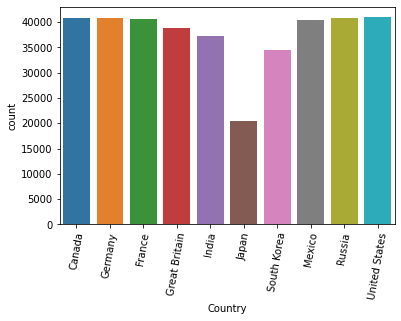

In [29]:
# Visually, the distribution of points for each country looks like this:
# We see that Japan scored a total of 2 times less points than any other country
# Perhaps this is due to the fact that data for Japan began to be collected later than for other countries
# Check this hypothesis below
sns.countplot(x='Country', data=df_full)
plt.xticks(rotation=80);

In [30]:
# Indeed, Japan's trend data was collected for 127 days, while other countries took 212 days
print(df_full.groupby('Country')['trending_date'].max() - df_full.groupby('Country')['trending_date'].min())

Country
Canada          212 days
France          212 days
Germany         212 days
Great Britain   212 days
India           212 days
Japan           127 days
Mexico          212 days
Russia          212 days
South Korea     212 days
United States   212 days
Name: trending_date, dtype: timedelta64[ns]


In [31]:
# Check if there is seasonality.
# To do this, first add a year-month trend column
test = df_full['trending_date'].astype('str')
df_full['Year_month_int'] = test.str.replace('-?', '', regex=True).str[0:6]

In [32]:
df_full['Year_month_int'] = df_full['Year_month_int'].astype('str')

In [33]:
# In total, we have information for a total of 8 months
print(df_full['Year_month_int'].nunique(), " месяцев")
print(df_full['Year_month_int'].unique())

8  месяцев
['201711' '201712' '201801' '201802' '201803' '201804' '201805' '201806']


## 2. Remove duplicates
<a id="2."></a>

### 2.1 Description of the problem with duplicates
<a id="2.1"></a>

In [36]:
# First, let's load our data into the database to be able to work with them using SQL queries.
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df_full.to_sql('youtube', engine, index=False, if_exists='replace')

For the first example, let's take the clip **Childish Gambino - This Is America (Official Video)**

In [35]:
query = """
SELECT video_id, title, Country, trending_date, views, likes, publish_date_no_tz
FROM youtube
WHERE video_id LIKE 'VYOjWnS4cMY'
ORDER BY trending_date
LIMIT 50
"""
pd.read_sql_query(query, engine)

video_id                                              title  \
0   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
1   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
2   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
3   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
4   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
5   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
6   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
7   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
8   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
9   VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
10  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
11  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
12  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
13  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
14  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
15  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
16  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
17  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
18  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
19  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
20  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
21  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
22  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
23  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
24  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
25  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
26  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
27  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
28  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
29  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
30  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
31  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
32  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
33  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
34  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
35  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
36  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
37  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
38  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
39  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
40  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
41  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
42  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
43  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
44  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
45  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
46  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
47  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
48  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
49  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   

          Country               trending_date      views    likes  \
0          Canada  2018-05-06 00:00:00.000000     546527   109193   
1          Mexico  2018-05-06 00:00:00.000000     546527   109235   
2          Russia  2018-05-06 00:00:00.000000     546527   109216   
3          Canada  2018-05-07 00:00:00.000000   14171087   801866   
4         Germany  2018-05-07 00:00:00.000000   14171087   801859   
5          France  201

The same 'video_id', trending date, country, views. But the likes are literally a few pieces different. And the line number of the record is different. Apparently YouTube API pulled the same video 2 times on the same day for some reason. And why are the views the same in dubbing, but there are no likes?
When a video is rapidly gaining views, it happens that YouTube freezes views for a while. And the statistics of likes sometimes continues to be displayed in a timely manner.

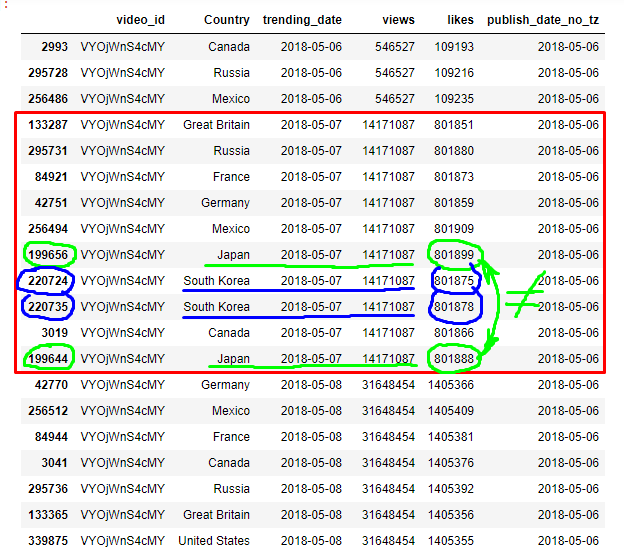

In [36]:
from PIL import Image
img = Image.open('data/pictures/stage_3/duplicates_in_the_dataset.png')
img

Also another example of a Korean boy band. **BTS (방탄소년단) 'FAKE LOVE' Official MV**

In [37]:
df_full[df_full['video_id'] == '7C2z4GqqS5E'][['video_id', 'Country', 'trending_date', 
                                'views', 'likes', 'publish_time_no_tz']].sort_values('trending_date', ascending=True).head(20)

video_id        Country trending_date     views    likes  \
3248    7C2z4GqqS5E         Canada    2018-05-19  39349927  3880074   
340272  7C2z4GqqS5E  United States    2018-05-19  39349927  3880071   
134215  7C2z4GqqS5E  Great Britain    2018-05-19  39349927  3880074   
42897   7C2z4GqqS5E        Germany    2018-05-19  39349927  3880074   
295835  7C2z4GqqS5E         Russia    2018-05-19  39349927  3880074   
256692  7C2z4GqqS5E         Mexico    2018-05-19  39349928  3880211   
85193   7C2z4GqqS5E         France    2018-05-19  39349927  3880074   
199774  7C2z4GqqS5E          Japan    2018-05-20  62796390  4470923   
220828  7C2z4GqqS5E    South Korea    2018-05-20  62796390  4470923   
220834  7C2z4GqqS5E    South Korea    2018-05-20  62796390  4470923   
256722  7C2z4GqqS5E         Mexico    2018-05-20  62796390  4470923   
256752  7C2z4GqqS5E         Mexico    2018-05-20  62796390  4470923   
295845  7C2z4GqqS5E         Russia    2018-05-20  62796390  4470923   
295858  7C2z4GqqS5E         Russia    2018-05-20  62796390  4470923   
340306  7C2z4GqqS5E  United States    2018-05-20  62796390  4470888   
199772  7C2z4GqqS5E          Japan    2018-05-20  62796390  4470923   
199771  7C2z4GqqS5E          Japan    2018-05-20  62796390  4470923   
199773  7C2z4GqqS5E          Japan    2018-05-20  62796390  4470923   
134289  7C2z4GqqS5E  Great Britain    2018-05-20  62796390  4470888   
85228   7C2z4GqqS5E         France    2018-05-20  62796390  4470923   

        publish_time_no_tz  
3248   2018-05-18 09:00:02  
340272 2018-05-18 09:00:02  
134215 2018-05-18 09:00:02  
42897  2018-05-18 09:00:02  
295835 2018-05-18 09:00:02  
256692 2018-05-18 09:00:02  
85193  2018-05-18 09:00:02  
199774 2018-05-18 09:00:02  
220828 2018-05-18 09:00:02  
220834 2018-05-18 09:00:02  
256722 2018-05-18 09:00:02  
256752 2018-05-18 09:00:02  
295845 2018-05-18 09:00:02  
295858 2018-05-18 09:00:02  
340306 2018-05-18 09:00:02  
199772 2018-05-18 09:00:02  
199771 2018-05-18 09:00:02  
199773 2018-05-18 09:00:02  
134289 2018-05-18 09:00:02  
85228  2018-05-18 09:00:02

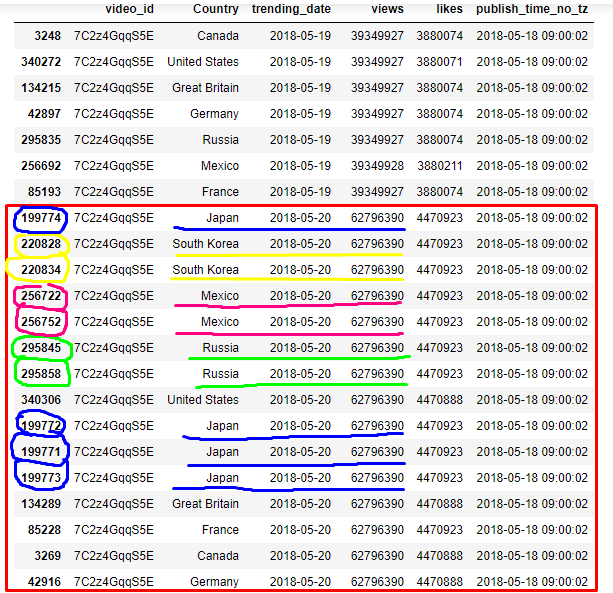

In [38]:
img = Image.open('data/pictures/stage_3/duplicates_korean_boys_band.png')
img

One of the solutions to the problem is to create a "group" key by connecting CONCAT () several lines into one. Specifically - 'video_id', 'title', 'trending_date', 'country'. And then group by the newly created key. As a result, duplicates will be removed.

In [39]:
df_korean_boys_band_duplicates = df_full[df_full['video_id'] == '7C2z4GqqS5E']
df_korean_boys_band_duplicates['new_id'] = df_korean_boys_band_duplicates['video_id'].str \
                        .cat(df_korean_boys_band_duplicates[['title', 'trending_date', 'Country']].astype('str'))

<ipython-input-39-e74147a322be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_korean_boys_band_duplicates['new_id'] = df_korean_boys_band_duplicates['video_id'].str \


Grouping rows by new key

In [40]:
df_korean_boys_band_duplicates.groupby('new_id')['new_id'].count()

new_id
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19Canada           1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19France           1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19Germany          1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19Great Britain    1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19Mexico           1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19Russia           1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-19United States    1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-20Canada           1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-20France           1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-20Germany          1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-20Great Britain    1
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-20Japan            4
7C2z4GqqS5EBTS (방탄소년단) 'FAKE LOVE' Official MV2018-05-20Mexico           2
7C2z4GqqS5EBTS (방탄

We see how dubbing "collapsed".

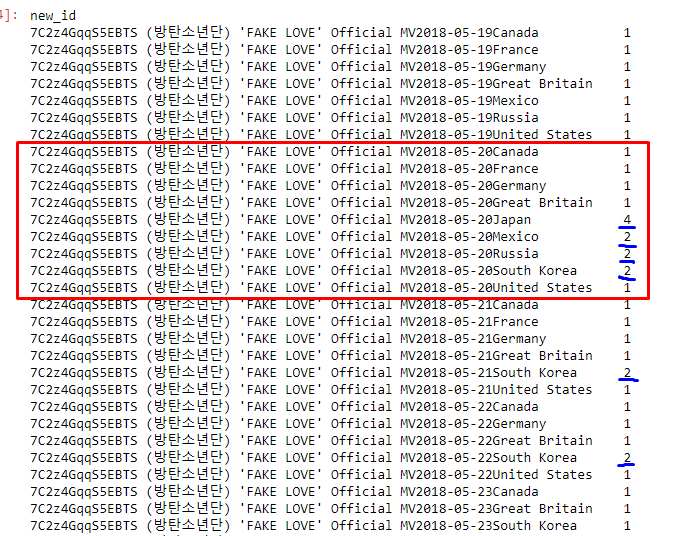

In [41]:
img = Image.open('data/pictures/stage_3/duplicates_korean_boys_band_no_duplicates.png')
img

### Problem 2 - there is a video where 'video_id' is undefined. Where it is undefined, it is replaced by the value '#NAME?'
#### is less of a problem than duplicates, but can still cause some trouble.

In [42]:
query = """
SELECT video_id, title, channel_title, trending_date, views, Country, publish_date_no_tz
FROM youtube
WHERE video_id = '#NAME?'
ORDER BY views DESC
LIMIT 10
"""
pd.read_sql_query(query, engine)

video_id                                              title  \
0   #NAME?              Maluma - El Préstamo (Official Video)   
1   #NAME?              Maluma - El Préstamo (Official Video)   
2   #NAME?              Maluma - El Préstamo (Official Video)   
3   #NAME?  PADMAN Official Trailer | Akshay Kumar | Sonam...   
4   #NAME?  PADMAN Official Trailer | Akshay Kumar | Sonam...   
5   #NAME?  PADMAN Official Trailer | Akshay Kumar | Sonam...   
6   #NAME?              Maluma - El Préstamo (Official Video)   
7   #NAME?  PADMAN Official Trailer | Akshay Kumar | Sonam...   
8   #NAME?  PADMAN Official Trailer | Akshay Kumar | Sonam...   
9   #NAME?  PADMAN Official Trailer | Akshay Kumar | Sonam...   

         channel_title               trending_date     views Country  \
0           MalumaVEVO  2018-03-14 00:00:00.000000  44726356  Mexico   
1           MalumaVEVO  2018-03-13 00:00:00.000000  39575633  Mexico   
2           MalumaVEVO  2018-03-12 00:00:00.000000  31870855  Mexico   
3  Sony Pictures India  2017-12-22 00:00:00.000000  28080774   India   
4  Sony Pictures India  2017-12-21 00:00:00.000000  26983244   India   
5  Sony Pictures India  2017-12-20 00:00:00.000000  25484419   India   
6           MalumaVEVO  2018-03-11 00:00:00.000000  24907224  Mexico   
7  Sony Pictures India  2017-12-19 00:00:00.000000  24065621   India   
8  Sony Pictures India  2017-12-18 00:00:00.000000  22497031   India   
9  Sony Pictures India  2017-12-17 00:00:00.000000  20620951   India   

           publish_date_no_tz  
0  2018-03-09 00:00:00.000000  
1  2018-03-09 00:00:00.000000  
2  2018-03-09 00:00:00.000000  
3  2017-12-15 00:00:00.000000  
4  2017-12-15 00:00:00.000000  
5  2017-12-15 00:00:00.000000  
6  2018-03-09 00:00:00.000000  
7  2017-12-15 00:00:00.000000  
8  2017-12-15 00:00:00.000000  
9  2017-12-15 00:00:00.000000

In [43]:
query = """
SELECT 
    country
    , count(*) as count_rows_with_video_id_error
    , count(DISTINCT title) as unique_videos_with_error_video_id
    , sum(views) as sum_of_trend_views_error_video_id
    , sum(sum(views)) OVER () as total_trend_views_error_video_id
FROM youtube
WHERE video_id = '#NAME?'
GROUP BY country
ORDER BY views DESC
"""
pd.read_sql_query(query, engine)

Country  count_rows_with_video_id_error  \
0  South Korea                             443   
1       Mexico                             516   
2        India                             511   
3        Japan                             282   
4       Russia                             560   

   unique_videos_with_error_video_id  sum_of_trend_views_error_video_id  \
0                                217                          113894937   
1                                440                          268038282   
2                                214                          765625280   
3                                183                           57692467   
4                                485                           96339901   

   total_trend_views_error_video_id  
0                        1301590867  
1                        1301590867  
2                        1301590867  
3                        1301590867  
4                        1301590867

Total video_id contains 2312 lines with '#NAME?' error. That when working, where it will be necessary to group by video_id, it may slightly distort the results.
Need to adjust 1505 video_id

In [44]:
query = """
SELECT
    count(*) as count_rows
    , count(DISTINCT video_id) as unique_video_id
    , count(DISTINCT title) as unique_title
    , count(DISTINCT title) as video_ids_that_need_to_be_corrected
FROM youtube
WHERE video_id = '#NAME?'
"""
pd.read_sql_query(query, engine)

count_rows  unique_video_id  unique_title  \
0        2312                1          1505   

   video_ids_that_need_to_be_corrected  
0                                 1505

The adjustment logic is the following: let's combine video_id and title into one column. As a result, we get 1505 new video_id, which we then insert instead of the value "#NAME?"

In [45]:
# "||" in sqlite - analogue of the CONCAT() function in PostgreSQL
query = """
SELECT
   count(DISTINCT video_id || title) as new_video_ids
FROM youtube
WHERE video_id = '#NAME?'
"""
pd.read_sql_query(query, engine)

new_video_ids
0           1505

Other than '#NAME?' there is also the value '#VALUE!', which also indicates an error in determining the video_id. There are 7 such values in total. The above method for '#NAME?' will solve this problem too.

In [46]:
query = """
SELECT video_id, title, channel_title, trending_date, views, Country, publish_date_no_tz
FROM youtube
WHERE video_id = '#VALUE!'
"""
pd.read_sql_query(query, engine)

video_id                                              title  \
0  #VALUE!  FARZAND | Official Teaser | Upcoming Marathi M...   
1  #VALUE!  FARZAND | Official Teaser | Upcoming Marathi M...   
2  #VALUE!  FARZAND | Official Teaser | Upcoming Marathi M...   
3  #VALUE!  ऐसे झूठ जिनको देख कर आप तुरंत विश्वास कर लेते ...   
4  #VALUE!  ऐसे झूठ जिनको देख कर आप तुरंत विश्वास कर लेते ...   
5  #VALUE!  ऐसे झूठ जिनको देख कर आप तुरंत विश्वास कर लेते ...   
6  #VALUE!  ऐसे झूठ जिनको देख कर आप तुरंत विश्वास कर लेते ...   

     channel_title               trending_date   views Country  \
0  Rajshri Marathi  2018-03-19 00:00:00.000000  111087   India   
1  Rajshri Marathi  2018-03-20 00:00:00.000000  156320   India   
2  Rajshri Marathi  2018-03-21 00:00:00.000000  206364   India   
3          Rahasya  2018-03-09 00:00:00.000000   68027   India   
4          Rahasya  2018-03-10 00:00:00.000000  143872   India   
5          Rahasya  2018-03-11 00:00:00.000000  233118   India   
6          Rahasya  2018-03-12 00:00:00.000000  258163   India   

           publish_date_no_tz  
0  2018-03-18 00:00:00.000000  
1  2018-03-18 00:00:00.000000  
2  2018-03-18 00:00:00.000000  
3  2018-03-08 00:00:00.000000  
4  2018-03-08 00:00:00.000000  
5  2018-03-08 00:00:00.000000  
6  2018-03-08 00:00:00.000000

### 2.2 Dealing with duplicates and undefined video_id
<a id="2.2"></a>

### 2.2.1 Solving the problem with undefined video_id
<a id="2.2.1"></a>

Cut lines that contain '#VALUE!' as video_id or '#NAME?'. And insert into an empty table.

In [47]:
df_duplicate_correction = df_full[(df_full['video_id'] == '#NAME?') | (df_full['video_id'] == '#VALUE!')]

In [48]:
# 2319 lines and 21 columns
df_duplicate_correction.shape

(2319, 20)

In [49]:
df_duplicate_correction.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'tags', 'views',
       'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'category', 'publish_time_no_tz', 'publish_date_no_tz',
       'Country', 'points', 'Year_month_int'],
      dtype='object')

We form a new column using the 'video_id' and 'title' concatenation

In [50]:
df_duplicate_correction['new_id'] = df_duplicate_correction['video_id'].str \
                                            .cat(df_duplicate_correction[['title']].astype('str'))

<ipython-input-50-c8a884a8779e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicate_correction['new_id'] = df_duplicate_correction['video_id'].str \


In [51]:
df_duplicate_correction.tail(1)

video_id trending_date  \
334972   #NAME?    2018-05-22   

                                                    title channel_title  \
334972  Мужское / Женское - Папа за полмиллиона. Выпус...  Первый канал   

                                                     tags   views  likes  \
334972  Семья|"помощь"|"родители"|"семья"|"предательст...  180233    610   

        dislikes  comment_count  \
334972       179            392   

                                        thumbnail_link  ...  ratings_disabled  \
334972  https://i.ytimg.com/vi/-f7pF0PBzg4/default.jpg  ...                 0   

        video_error_or_removed  \
334972                       0   

                                              description category  \
334972  Бывшие супруги Ирина и Виктор Сысоевы из Сысер...    Shows   

        publish_time_no_tz publish_date_no_tz Country points  Year_month_int  \
334972 2018-05-21 15:10:54         2018-05-21  Russia      1          201805   

                                                   new_id  
334972  #NAME?Мужское / Женское - Папа за полмиллиона....  

[1 rows x 21 columns]

In [52]:
# An example of a new long key
df_duplicate_correction['new_id'].tail()

334829    #NAME?Вечерний Ургант. Сергей Безруков и Антон...
334857    #NAME?Мужское / Женское - Моя ужасная история....
334891    #NAME?На самом деле - «Я - настоящий отец ребе...
334915    #NAME?Вечерний Ургант. Валерий Сюткин , группа...
334972    #NAME?Мужское / Женское - Папа за полмиллиона....
Name: new_id, dtype: object

To make our key shorter and perform its functions, we will generate a new key.

In [53]:
# 1507 unique values of the new long key
df_duplicate_correction['new_id'].nunique()

1507

Now let's generate a new short 14-digit key

In [54]:
# We form an empty dictionary (can contain only 1 key)
id_dict = {}

# Create an alphabet from which we will "sculpt" the key by random selection from the string. We wrap the alphabet in a numpy array.
# The pandas and numpy libraries are written in C, so unlike Python, they are ten times faster.
alphabet = np.array(list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890'))

# Loop through the unique list of long keys that we got by concatenation.
# And insert into our dictionary
for i in df_duplicate_correction['new_id'].unique():
    a = np.random.choice(alphabet, size=14)
    a = a.tolist()
    a = ''.join(a)
    id_dict.update({i: a})

In [55]:
# List 'long key': 'randomly generated short key'
count = 0
for i in id_dict:
    count += 1
    if count < 10:
        print(i, ": ", id_dict[i])

#NAME?Sucha Yaar - JATTAN DA PROGRAM [Official Teaser] | Art Attack | Upcoming Beat Punjabi Song 2017 :  p2ELABMYPlHwvr
#NAME?DILL TON BLACCK Video Song | Jassi Gill Feat. Badshah | Jaani, B Praak | New Song 2018 :  q37feQyNZXk0FL
#NAME?Yentha Sakkagunnaave Lyrical - Rangasthalam Songs | Ram Charan, Samantha, Devi Sri Prasad :  smaLT5mTVq1fg9
#NAME?Ranga Ranga Rangasthalaana Lyrical - Rangasthalam Songs - Ram Charan, Devi Sri Prasad :  BPIAthEGbMVUpK
#NAME?Most Wanted Abbayi Lyrical || MLA Movie Songs || Nandamuri Kalyanram, Kajal Aggarwal || Mani Sharma :  WqrSqyWNLLJUMl
#NAME?Kaali Hummer (Official Video) Maninder Buttar | Happy Raikoti | Sukh Sanghera  | White Hill Music :  rdwwSfYF6TALVW
#NAME?BEWAFA TU - GURI  (Full Song) Satti Dhillon | Latest Punjabi Sad Song 2018 | Geet MP3 :  MFk9eO34fKQwfY
#NAME?Soniye Dil Nayi Video Song | Baaghi 2 | Tiger Shroff | Disha Patani | Ankit Tiwari |Shruti Pathak :  l4H9hzlbHbNUSe
#NAME?Jodi Teri Meri | Official Video | Jassi Gill | Desi Crew | La

In [56]:
# This is how the generator of random words from a list of letters and characters works separately
alphabet = np.array(list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890'))
a = np.random.choice(alphabet, size=14)
a = a.tolist()
a = ''.join(a)
a

'vyXL7sTEA3WP1V'

In [57]:
# Now we turn our dictionary into a lookup table, from where we will later take short keys by JOIN
id_dict_df = pd.DataFrame(id_dict.items(), columns=['long_key', 'short_key'])
id_dict_df.head()

long_key       short_key
0  #NAME?Sucha Yaar - JATTAN DA PROGRAM [Official...  p2ELABMYPlHwvr
1  #NAME?DILL TON BLACCK Video Song | Jassi Gill ...  q37feQyNZXk0FL
2  #NAME?Yentha Sakkagunnaave Lyrical - Rangastha...  smaLT5mTVq1fg9
3  #NAME?Ranga Ranga Rangasthalaana Lyrical - Ran...  BPIAthEGbMVUpK
4  #NAME?Most Wanted Abbayi Lyrical || MLA Movie ...  WqrSqyWNLLJUMl

In [58]:
df_duplicate_correction.head(1)

video_id trending_date  \
161548   #NAME?    2017-11-30   

                                                    title       channel_title  \
161548  Sucha Yaar - JATTAN DA PROGRAM [Official Tease...  Art Attack Records   

                                                     tags  views  likes  \
161548  INDER CHAHAL|"DALJIT DOSANJH"|"AMMY VIRK"|"MAN...  18580    475   

        dislikes  comment_count  \
161548        19             70   

                                        thumbnail_link  ...  ratings_disabled  \
161548  https://i.ytimg.com/vi/-yJpygjq7c8/default.jpg  ...                 0   

        video_error_or_removed  \
161548                       0   

                                              description category  \
161548  Presenting the Official Teaser ofJATTAN DA PRO...    Music   

        publish_time_no_tz publish_date_no_tz Country points  Year_month_int  \
161548 2017-11-28 13:41:05         2017-11-28   India      1          201711   

                                                   new_id  
161548  #NAME?Sucha Yaar - JATTAN DA PROGRAM [Official...  

[1 rows x 21 columns]

In [59]:
# INNER JOIN
df_duplicate_correction_short_key = 0
df_duplicate_correction_short_key = pd.merge(df_duplicate_correction, id_dict_df, left_on='new_id', right_on='long_key')

In [60]:
# This is what our dataset looks like with the new short key
df_duplicate_correction_short_key[['short_key', 'title', 'channel_title', 'trending_date', 'views', 'Country']].head(20)

short_key                                              title  \
0   p2ELABMYPlHwvr  Sucha Yaar - JATTAN DA PROGRAM [Official Tease...   
1   p2ELABMYPlHwvr  Sucha Yaar - JATTAN DA PROGRAM [Official Tease...   
2   q37feQyNZXk0FL  DILL TON BLACCK Video Song | Jassi Gill Feat. ...   
3   q37feQyNZXk0FL  DILL TON BLACCK Video Song | Jassi Gill Feat. ...   
4   q37feQyNZXk0FL  DILL TON BLACCK Video Song | Jassi Gill Feat. ...   
5   smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
6   smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
7   smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
8   smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
9   smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
10  smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
11  smaLT5mTVq1fg9  Yentha Sakkagunnaave Lyrical - Rangasthalam So...   
12  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
13  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
14  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
15  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
16  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
17  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
18  BPIAthEGbMVUpK  Ranga Ranga Rangasthalaana Lyrical - Rangastha...   
19  WqrSqyWNLLJUMl  Most Wanted Abbayi Lyrical || MLA Movie Songs ...   

              channel_title trending_date    views Country  
0        Art Attack Records    2017-11-30    18580   India  
1        Art Attack Records    2017-12-01    41874   India  
2                  T-Series    2018-01-25  3455624   India  
3                  T-Series    2018-01-26  6019930   India  
4                  T-Series    2018-01-27  8151118   India  
5   Lahari Music | T-Series    2018-02-14  2555559   India  
6   Lahari Music | T-Series    2018-02-15  4494981   India  
7   Lahari Music | T-Series    2018-02-16  5020485   India  
8   Lahari Music | T-Series    2018-02-17  5752277   India  
9   Lahari Music | T-Series    2018-02-18  6388386   India  
10  Lahari Music | T-Series    2018-02-19  6878437   India  
11  Lahari Music | T-Series    2018-02-20  7335213   India  
12  Lahari Music | T-Series    2018-03-03  2260328   India  
13  Lahari Music | T-Series    2018-03-03  2260328   India  
14  Lahari Music | T-Series    2018-03-04  3390403   India  
15  Lahari Music | T-Series    2018-03-05  4014173   India  
16  Lahari Music | T-Series    2018-03-06  4328477   India  
17  Lahari Music | T-Series    2018-03-07  4694970   India  
18  Lahari Music | T-Series    2018-03-08  4981660   India  
19             Aditya Music    2018-03-06   444418   India

In [61]:
df_duplicate_correction_short_key.head(1)

video_id trending_date                                              title  \
0   #NAME?    2017-11-30  Sucha Yaar - JATTAN DA PROGRAM [Official Tease...   

        channel_title                                               tags  \
0  Art Attack Records  INDER CHAHAL|"DALJIT DOSANJH"|"AMMY VIRK"|"MAN...   

   views  likes  dislikes  comment_count  \
0  18580    475        19             70   

                                   thumbnail_link  ...  \
0  https://i.ytimg.com/vi/-yJpygjq7c8/default.jpg  ...   

                                         description  category  \
0  Presenting the Official Teaser ofJATTAN DA PRO...     Music   

   publish_time_no_tz publish_date_no_tz Country points Year_month_int  \
0 2017-11-28 13:41:05         2017-11-28   India      1         201711   

                                              new_id  \
0  #NAME?Sucha Yaar - JATTAN DA PROGRAM [Official...   

                                            long_key       short_key  
0  #NAME?Sucha Yaar - JATTAN DA PROGRAM [Official...  p2ELABMYPlHwvr  

[1 rows x 23 columns]

In [62]:
# Now remove unnecessary columns
df_duplicate_correction_short_key = df_duplicate_correction_short_key.drop(['video_id', 'new_id', 'long_key'], axis=1)

In [63]:
# Rename 'short_key' to 'video_id'
df_duplicate_correction_short_key.rename(columns={'short_key': 'video_id'}, inplace=True)

In [64]:
df_duplicate_correction_short_key.columns

Index(['trending_date', 'title', 'channel_title', 'tags', 'views', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'video_error_or_removed', 'description', 'category',
       'publish_time_no_tz', 'publish_date_no_tz', 'Country', 'points',
       'Year_month_int', 'video_id'],
      dtype='object')

In [65]:
df_without_name_value = df_full[(df_full['video_id'] != '#NAME?') & (df_full['video_id'] != '#VALUE!')]

In [66]:
print(df_full.shape[0])
print(df_without_name_value.shape[0])
print(df_duplicate_correction_short_key.shape[0])

375942
373623
2319


In [67]:
# UNION ALL
df_union_all = pd.concat([df_without_name_value, df_duplicate_correction_short_key])

In [68]:
df_union_all.shape

(375942, 20)

In [69]:
# 0 values '#NAME?' or '#VALUE!' in the 'video_id' column
# With the same 375942 lines and 21 columns
print(df_union_all[(df_union_all['video_id'] == '#NAME?') | (df_union_all['video_id'] == '#VALUE!')].shape[0])
print("Исходный датасет: ", df_full.shape)
print("Обработанный датасет: ", df_union_all.shape)

0
Исходный датасет:  (375942, 20)
Обработанный датасет:  (375942, 20)


### 2.2.2 Solving the problem with duplicate lines
<a id="2.2.2"></a>

In [70]:
# Concatenate 'video_id', 'title', 'trending_date', 'Country' into one string.
df_union_all['new_id'] = df_union_all['video_id'].str.cat(df_union_all[['title', 'trending_date', 'Country']].astype('str'))

In [71]:
df_union_all['new_id'].head()

0    n1WpP7iowLcEminem - Walk On Water (Audio) ft. ...
1    2Vv-BfVoq4gEd Sheeran - Perfect (Official Musi...
2    H1KBHFXm2Bg21 Savage - Bank Account (Official ...
3    7MxiQ4v0EnEDaang ( Full Video ) | Mankirt Aula...
4    j67FgNEvyh8Telefoon || Babbu Maan || Promo || ...
Name: new_id, dtype: object

In [72]:
df_union_all.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'tags', 'views',
       'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'category', 'publish_time_no_tz', 'publish_date_no_tz',
       'Country', 'points', 'Year_month_int', 'new_id'],
      dtype='object')

In [73]:
# Group by the 'new_id' concatenation, thereby removing duplicates
df_union_all_grouped = df_union_all.groupby('new_id').agg({'video_id': np.unique, 'trending_date': np.max, 'title': np.unique, 
                                'channel_title': np.unique, 'tags': np.unique, 'views': np.max,
       'likes': np.max, 'dislikes': np.max, 'comment_count': np.max, 'thumbnail_link': np.unique,
       'comments_disabled': np.max, 'ratings_disabled': np.max, 'video_error_or_removed': np.max,
       'description': np.unique, 'category': np.unique, 'publish_time_no_tz': np.max, 'publish_date_no_tz': np.max,
       'Country': np.unique, 'points': np.max, 'Year_month_int': np.max})

In [74]:
# Duplicates in data were 13230 / 375942 = 3.5%
print("Строки исходного датасета: ", df_full.shape[0])
print("Строки обработанного датасета: ", df_union_all_grouped.shape[0])
print("Удаленные дубликаты: ", df_full.shape[0] - df_union_all_grouped.shape[0])

Строки исходного датасета:  375942
Строки обработанного датасета:  362712
Удаленные дубликаты:  13230


### 2.2.3 Checking the result of our work for duplicates
<a id="2.2.3"></a>

In [75]:
# Update the index as 0,1,2 ...
df_union_all_grouped = df_union_all_grouped.reset_index()

In [76]:
# Remove the 'new_id' column
df_union_all_grouped.drop('new_id', axis=1, inplace=True)

In [77]:
df_union_all_grouped[df_union_all_grouped['video_id'] == 'VYOjWnS4cMY'][['video_id', 'Country', 'trending_date', 
                                'views', 'likes', 'publish_time_no_tz']].sort_values('trending_date', ascending=True).head(15)

video_id        Country trending_date     views    likes  \
183640  VYOjWnS4cMY         Canada    2018-05-06    546527   109193   
183641  VYOjWnS4cMY         Mexico    2018-05-06    546527   109235   
183642  VYOjWnS4cMY         Russia    2018-05-06    546527   109216   
183649  VYOjWnS4cMY         Russia    2018-05-07  14171087   801880   
183648  VYOjWnS4cMY         Mexico    2018-05-07  14171087   801909   
183647  VYOjWnS4cMY          Japan    2018-05-07  14171087   801899   
183650  VYOjWnS4cMY    South Korea    2018-05-07  14171087   801878   
183645  VYOjWnS4cMY        Germany    2018-05-07  14171087   801859   
183644  VYOjWnS4cMY         France    2018-05-07  14171087   801873   
183643  VYOjWnS4cMY         Canada    2018-05-07  14171087   801866   
183646  VYOjWnS4cMY  Great Britain    2018-05-07  14171087   801851   
183651  VYOjWnS4cMY         Canada    2018-05-08  31648454  1405376   
183652  VYOjWnS4cMY         France    2018-05-08  31648454  1405381   
183653  VYOjWnS4cMY        Germany    2018-05-08  31648454  1405366   
183654  VYOjWnS4cMY  Great Britain    2018-05-08  31648454  1405356   

        publish_time_no_tz  
183640 2018-05-06 04:00:07  
183641 2018-05-06 04:00:07  
183642 2018-05-06 04:00:07  
183649 2018-05-06 04:00:07  
183648 2018-05-06 04:00:07  
183647 2018-05-06 04:00:07  
183650 2018-05-06 04:00:07  
183645 2018-05-06 04:00:07  
183644 2018-05-06 04:00:07  
183643 2018-05-06 04:00:07  
183646 2018-05-06 04:00:07  
183651 2018-05-06 04:00:07  
183652 2018-05-06 04:00:07  
183653 2018-05-06 04:00:07  
183654 2018-05-06 04:00:07

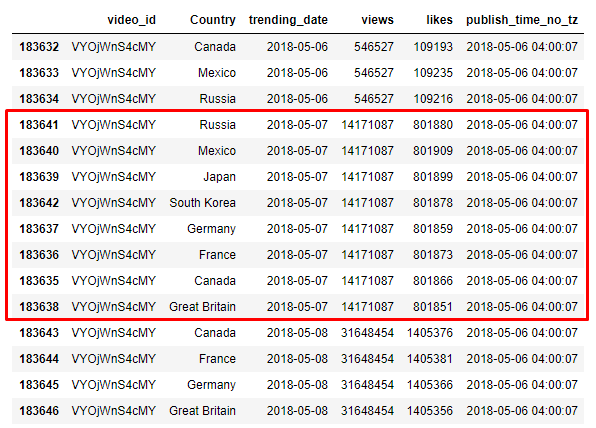

In [78]:
img = Image.open('data/pictures/stage_3/no_duplicates_this_is_America.png')
img

Boyband **BTS (방탄소년단) 'FAKE LOVE' Official MV.** No duplicates

In [79]:
df_union_all_grouped[df_union_all_grouped['video_id'] == '7C2z4GqqS5E'][['video_id', 'Country', 'trending_date', 
                                'views', 'likes', 'publish_time_no_tz']].sort_values('trending_date', ascending=True).head(20)

video_id        Country trending_date     views    likes  \
44402  7C2z4GqqS5E         Canada    2018-05-19  39349927  3880074   
44403  7C2z4GqqS5E         France    2018-05-19  39349927  3880074   
44404  7C2z4GqqS5E        Germany    2018-05-19  39349927  3880074   
44405  7C2z4GqqS5E  Great Britain    2018-05-19  39349927  3880074   
44406  7C2z4GqqS5E         Mexico    2018-05-19  39349928  3880211   
44407  7C2z4GqqS5E         Russia    2018-05-19  39349927  3880074   
44408  7C2z4GqqS5E  United States    2018-05-19  39349927  3880071   
44417  7C2z4GqqS5E  United States    2018-05-20  62796390  4470888   
44416  7C2z4GqqS5E    South Korea    2018-05-20  62796390  4470923   
44415  7C2z4GqqS5E         Russia    2018-05-20  62796390  4470923   
44414  7C2z4GqqS5E         Mexico    2018-05-20  62796390  4470923   
44413  7C2z4GqqS5E          Japan    2018-05-20  62796390  4470923   
44412  7C2z4GqqS5E  Great Britain    2018-05-20  62796390  4470888   
44411  7C2z4GqqS5E        Germany    2018-05-20  62796390  4470888   
44410  7C2z4GqqS5E         France    2018-05-20  62796390  4470923   
44409  7C2z4GqqS5E         Canada    2018-05-20  62796390  4470888   
44418  7C2z4GqqS5E         Canada    2018-05-21  65396157  4750254   
44419  7C2z4GqqS5E         France    2018-05-21  65396157  4750254   
44420  7C2z4GqqS5E        Germany    2018-05-21  65396157  4750254   
44421  7C2z4GqqS5E  Great Britain    2018-05-21  65396157  4750245   

       publish_time_no_tz  
44402 2018-05-18 09:00:02  
44403 2018-05-18 09:00:02  
44404 2018-05-18 09:00:02  
44405 2018-05-18 09:00:02  
44406 2018-05-18 09:00:02  
44407 2018-05-18 09:00:02  
44408 2018-05-18 09:00:02  
44417 2018-05-18 09:00:02  
44416 2018-05-18 09:00:02  
44415 2018-05-18 09:00:02  
44414 2018-05-18 09:00:02  
44413 2018-05-18 09:00:02  
44412 2018-05-18 09:00:02  
44411 2018-05-18 09:00:02  
44410 2018-05-18 09:00:02  
44409 2018-05-18 09:00:02  
44418 2018-05-18 09:00:02  
44419 2018-05-18 09:00:02  
44420 2018-05-18 09:00:02  
44421 2018-05-18 09:00:02

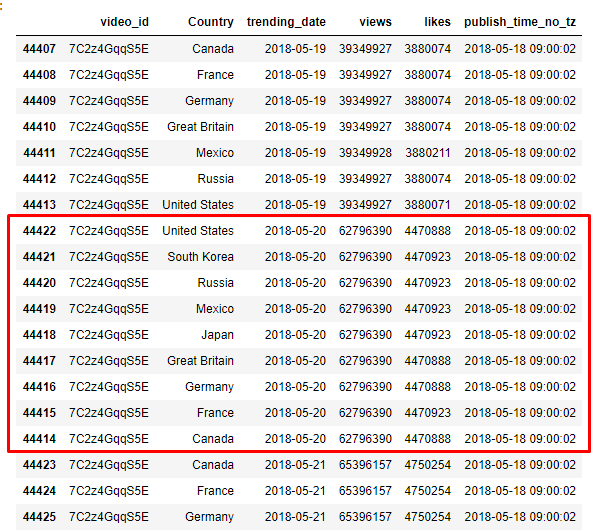

In [80]:
img = Image.open('data/pictures/stage_3/boys_band_no_duplicates.png')
img

In [81]:
# Upload the processed dataset to a .csv file

#df_union_all_grouped.to_csv \
#(r'C:\Users\b\Data_Science\Resume\Data_Analyst\df_union_all_grouped_no_duplicates_27_02_2021.csv', 
 #index = False, header=True)

## 3. Answers to questions from employees from the marketing department
<a id="3."></a>

In [4]:
# Load our processed dataset without duplicates
df_no_duplicates = pd.read_csv('df_union_all_grouped_no_duplicates_27_02_2021.csv')

In [5]:
df_no_duplicates.head(2)

video_id        trending_date  \
0  --1skHapGUc  2018-02-10 00:00:00   
1  --2K8l6BWfw  2018-03-06 00:00:00   

                                               title  channel_title  \
0  SI TE RÍES, PIERDES (NIVEL ASIÁTICO) #51 Los M...   TheChacal547   
1                   La Relève #2 : Jessica Rodrigues  Georgette Mag   

                                                tags  views  likes  dislikes  \
0  Videos de Risa|"Si te ries pierdes"|"videos gr...  30914    483        77   
1  Jessica Rodrigues"|"jumping"|"horse"|"cheval"|...   4822    694         4   

   comment_count                                  thumbnail_link  ...  \
0             81  https://i.ytimg.com/vi/--1skHapGUc/default.jpg  ...   
1             34  https://i.ytimg.com/vi/--2K8l6BWfw/default.jpg  ...   

   ratings_disabled  video_error_or_removed  \
0                 0                       0   
1                 0                       0   

                                         description        category  \
0  Video para partirse de risa! pero cuidado, int...   Entertainment   
1  Retrouve-nous sur ➼ http://www.georgettemag.co...  Pets & Animals   

    publish_time_no_tz   publish_date_no_tz Country points  Year_month_int  \
0  2018-02-09 19:04:43  2018-02-09 00:00:00  Mexico      1          201802   
1  2018-03-05 13:37:34  2018-03-05 00:00:00  France      1          201803   

   days_since_publish  
0                   1  
1                   1  

[2 rows x 21 columns]

### 3.1 What factors affect video trending
<a id="3.1"></a>

Since the same video can trend for several days in a row, in order to analyze the correlation, we need to group each video by 'video_id', while displaying the maximum views, likes, dislikes and total points.

In [24]:
df_grouped_video_id = df_no_duplicates.groupby('video_id').agg({'video_id': np.unique, 'views': np.max, 
                                                    'likes': np.max, 'dislikes': np.max, 'comment_count': np.max, 
                                                    'comments_disabled': np.max, 'ratings_disabled': np.max, 
                                                    'video_error_or_removed': np.max, 'points': np.sum})

In [25]:
df_grouped_video_id.head()

video_id   views  likes  dislikes  comment_count  \
video_id                                                           
--1skHapGUc  --1skHapGUc   30914    483        77             81   
--2K8l6BWfw  --2K8l6BWfw    4822    694         4             34   
--45ws7CEN0  --45ws7CEN0  309197   3837       516            278   
--6vcer7XYQ  --6vcer7XYQ  414012   2161       331            416   
--728h8mnDY  --728h8mnDY   39535   2573        51            269   

             comments_disabled  ratings_disabled  video_error_or_removed  \
video_id                                                                   
--1skHapGUc                  0                 0                       0   
--2K8l6BWfw                  0                 0                       0   
--45ws7CEN0                  0                 0                       0   
--6vcer7XYQ                  0                 0                       0   
--728h8mnDY                  0                 0                       0   

             points  
video_id             
--1skHapGUc       1  
--2K8l6BWfw       1  
--45ws7CEN0       3  
--6vcer7XYQ       3  
--728h8mnDY       2

**Introduce the following concepts:**

**0 - 0.3** - very weak correlation
**0.3 - 0.5** - weak correlation
**0.5 - 0.7** - average correlation
**0.7 - 0.9** - high correlation
**0.9 - 1** - very high correlation

As we can see, if we take a cross section for all countries, there is a weak correlation between getting into trends (number of points) and likes / views.
By the ratio of likes / views, comments / likes - high correlation
By the ratio of dislikes / comments - average correlation
By the ratio of views / comments, dislikes / likes, views / dislikes - a weak correlation

What can be concluded from this - **the more views and likes a video gets, the more likely the video is to trend** (relative to other changes). But with one caveat, correlation is not causation. Correlation simply shows that as one variable increases, the second variable increases. And it can grow because of some third variable (or factor), which just AFFECTS both.

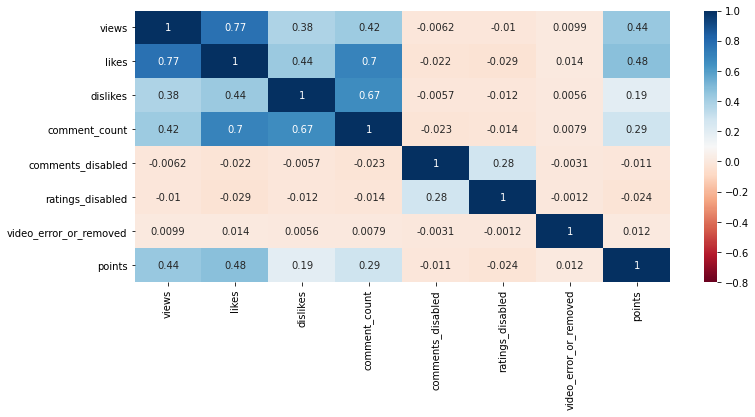

In [26]:
plt.figure(figsize=(12, 5))
sns.heatmap(df_grouped_video_id.corr(), annot=True, cmap='RdBu', vmin=-0.8);

### 3.2 What are the taste preferences of people from different countries?
<a id="3.2"></a>

We can see on the graph that the taste preferences of residents of different countries are very diverse in some places, but converge in others.
For example, in **Britain** the category "Music" is most in demand (35% of all trend positions).
**India** has the highest percentage of the "Entertainment" category (45%) of any country.
**South Korea** stands out among other countries for its interest in "News and Politics" (on average, the percentage of interest in this category is 2 times higher than in other countries - 22%).
In **Russia** people are most interested in the topic "People and Blogs" (25%).
But **USA, Canada, Germany, Mexico, India, Japan** are characterized by a rather high need for entertainment content.
The most apolitical and detached from the news - Japan (7%), Britain (3%), USA (6%), Germany (7%)

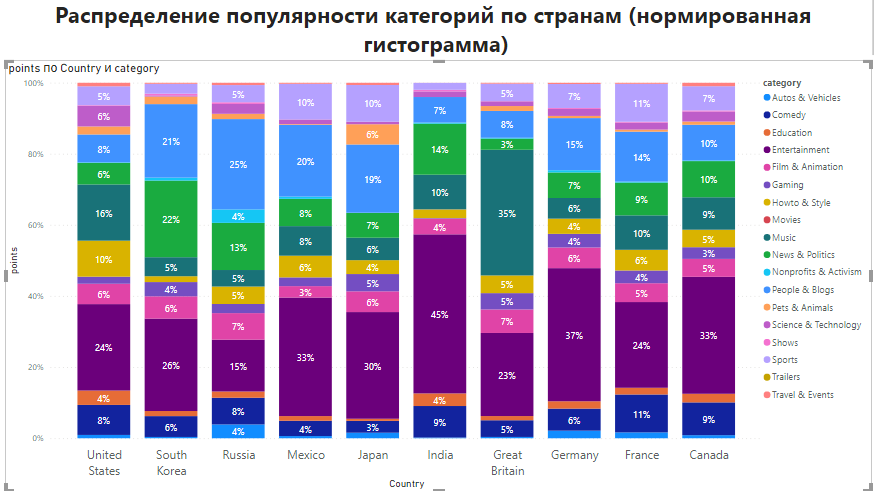

In [6]:
img = Image.open('data/pictures/no_duplicates/popularity_by_country.png')
img

Based on these data, we will try to draw up a portrait of a resident of a particular country. For example, let's take Russia. In order to describe the portrait, we need to define a certain "norm" - the average value among all countries. And we will compare each category of an individual country with an average value. When calculating the average value of all countries, we exclude the considered country so that it does not distort the result. For convenience, we will use SQL queries that we will send using the SQLAlchemy library. This can also be implemented in PowerBI using DAX formulas.

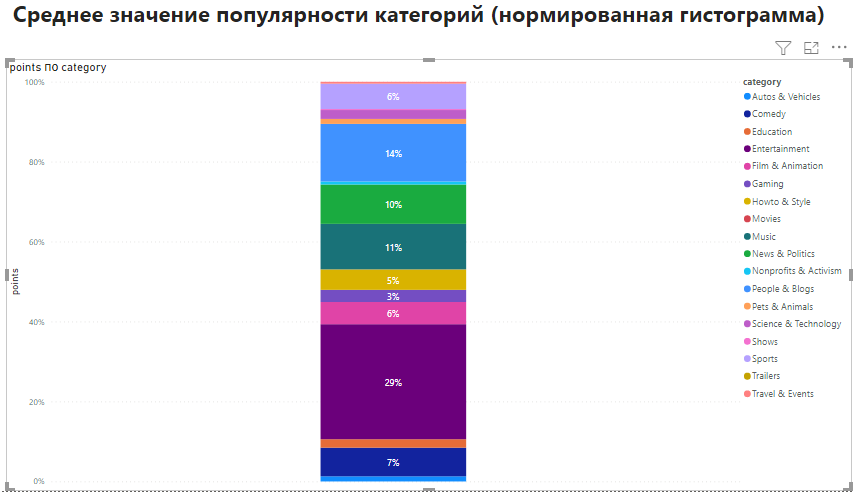

In [12]:
img = Image.open('data/pictures/no_duplicates/average_category_popularity.png')
img

### 3.3 How taste preferences of Russians and residents of other countries differ (on average)
<a id="3.3"></a>

In [37]:
# Create a 'youtube' table in the database. The database will be loaded into RAM.
# If there was a huge table - then I would save the database to the hard disk.
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

df_no_duplicates.to_sql('youtube', engine, index=False, if_exists='replace')

Based on the request, it turns out that a resident of Russia:

1. Russians are almost 3 times more interested in the topic "Auto and transport" than the average population of other countries
2. Russian refers to the genre of "Humor" in the same way as residents of other countries
3. But in the category "Education" the Russian is interested in 2 times less than the user of Youtube in other countries
4. Also in the genre of "Entertainment" Russians are 2 times less interested than residents of other countries
5. Russians are 40% more interested in the Film and Animation category
6. Russians are 33% less interested in the "Games" category
7. Russians show 22% less interest in the "DIY and style" category.
8. Russians have no interest in the "Cinema" category, like the rest of Youtube users
9. "Music" interests Russians 3 times less than residents of other countries
10. In the News & Politics category, Russians are 44% more interested than other countries
11. But in the category "Non-profit organizations and activism" Russians show increased interest - more than 3 times higher
12. Russians are 1.92 times more interested in the category "People and Blogs"
13. Russians treat "Animals" the same way as residents of other countries, showing very little interest.
14. Russians have the same low interest in "Science and Technology" as residents of other countries
15. Russians and foreigners have practically zero interest in the "Show"
16. Russians are 33% less interested in Sport
17. In the category "Travel and Events", Russians have almost zero interest, as well as residents of other countries

In [8]:
query = """
SELECT 
    DISTINCT y.category
    , sum(y.points) OVER(PARTITION BY y.category) AS category_points
    , sum(y.points) OVER () AS total_points
    , sum(y.points) OVER(PARTITION BY y.category) * 100 / 
            sum(y.points) OVER() AS average_pct_without_{country}
    , y1.percentage_{country}
    , y1.percentage_{country} - sum(y.points) OVER(PARTITION BY y.category) * 100 / 
            sum(y.points) OVER() as abs_pct_diff_to_{country}
FROM youtube y
INNER JOIN (
        SELECT 
            DISTINCT y.category
            , sum(y.points) OVER(PARTITION BY y.category) * 100 / 
                    sum(y.points) OVER() AS percentage_{country}
        FROM youtube y
        WHERE y.Country = '{full_country_name}'
    ) AS y1 ON y1.category = y.category
WHERE y.Country != '{full_country_name}'
ORDER BY y.category ASC;
""".format(country='russia', full_country_name='Russia')

pd.read_sql_query(query, engine)

category  category_points  total_points  \
0        Autos & Vehicles             3095        322018   
1                  Comedy            22931        322018   
2               Education             6958        322018   
3           Entertainment            98429        322018   
4        Film & Animation            17108        322018   
5                  Gaming            10010        322018   
6           Howto & Style            16547        322018   
7                  Movies               29        322018   
8                   Music            39410        322018   
9         News & Politics            30302        322018   
10  Nonprofits & Activism             1227        322018   
11         People & Blogs            41908        322018   
12         Pets & Animals             3916        322018   
13   Science & Technology             6931        322018   
14                  Shows              714        322018   
15                 Sports            21045        322018   
16        Travel & Events             1458        322018   

    average_pct_without_russia  percentage_russia  abs_pct_diff_to_russia  
0                            0                  3                       3  
1                            7                  7                       0  
2                            2                  1                      -1  
3                           30                 14                     -16  
4                            5                  7                       2  
5                            3                  2                      -1  
6                            5                  4                      -1  
7                            0                  0                       0  
8                           12                  4                      -8  
9                            9                 13                       4  
10                           0                  3                       3  
11                          13                 25                      12  
12                           1                  1                       0  
13                           2                  2                       0  
14                           0                  0                       0  
15                           6                  4                      -2  
16                           0                  0                       0

### 3.4 Is it true that Indians and Germans watch the same thing?
<a id="3.4"></a>

As we can see on the normalized histogram, the tastes of the Germans are generally different from the taste of the Indians.
Let's go through the categories and compare the percentage of popularity.

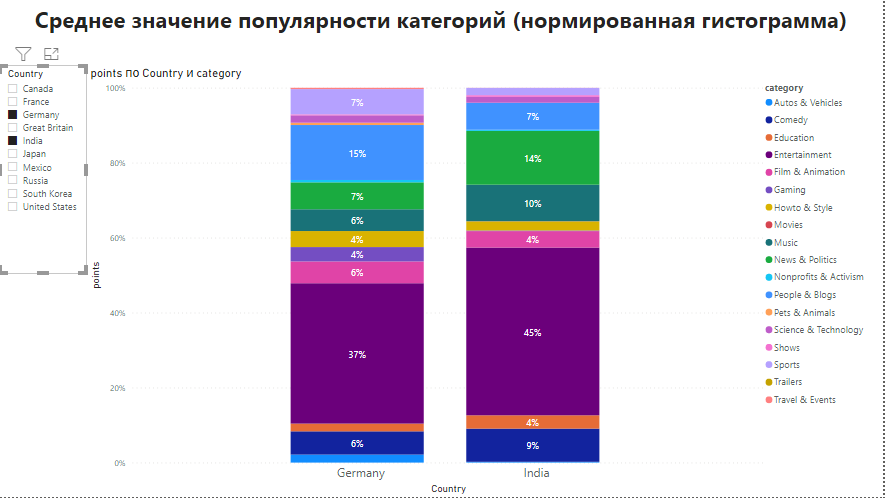

In [16]:
img = Image.open('data/pictures/no_duplicates/popularity_germany_india.png')
img

We will "measure" relative to the Germans

1. A German is more than 2 times more interested in the topic "Auto and Transport" than an Indian
2. The German is 33% less interested in the "Humor" genre than the Indian
3. In the category "Education" the German is 33% less interested than the Indian
4. Also in the Entertainment genre, Germans are 16% less interested than Indians.
5. Germans are 25% more interested in the Film and Animation category than Indians.
6. But in the category "Games" the Germans have more than 3 times higher interest than the Indians
7. In the category "DIY and style" the Germans show 2 times more interest than the Indians.
8. The Germans have no interest in the “Cinema” category, just like the Indians
9. "Music" interests the Germans 2 times less than the Indians
10. In the "News and Politics" category, the Germans are 2 times less interested than the Indians
11. In the category "Non-profit organizations and activism" Germans and Indians show indifference.
12. In the category "People and Blogs" Germans show 2 times higher interest than Indians
13. To "Animals" Germans and Indians demonstrate unity in indifference
14. Germans and Indians equally show little interest in "Science and Technology"
15. And again, Germans and Indians are almost equally indifferent to the "Show"
16. But the Germans show 6 times higher interest in Sport than the Indians
17. Germans and Indians are indifferent to the category "Travel and Events"

In [9]:
query = """
SELECT
    DISTINCT y.category
    , sum(y.points) OVER (PARTITION BY y.category) AS germany_category_points
    , sum(y.points) OVER () as germany_total_points
    , sum(y.points) OVER (PARTITION BY y.category) * 100 /
        sum(y.points) OVER () AS germany_percentage
    , y1.indian_percentage
    , sum(y.points) OVER (PARTITION BY y.category) * 100 /
        sum(y.points) OVER () - y1.indian_percentage AS germany_to_india_abs_pct_diff
FROM youtube y
INNER JOIN (
    SELECT 
        DISTINCT y.category AS category
        , sum(y.points) OVER(PARTITION BY y.category) * 100 /
                sum(y.points) OVER() AS indian_percentage
        FROM youtube y
        WHERE y.Country = 'India'
    ) AS y1 ON y.category = y1.category
WHERE y.Country = 'Germany'
ORDER BY y.category ASC;
"""

pd.read_sql_query(query, engine)

category  germany_category_points  germany_total_points  \
0        Autos & Vehicles                      873                 40839   
1                  Comedy                     2534                 40839   
2               Education                      844                 40839   
3           Entertainment                    15292                 40839   
4        Film & Animation                     2376                 40839   
5                  Gaming                     1565                 40839   
6           Howto & Style                     1745                 40839   
7                  Movies                        2                 40839   
8                   Music                     2372                 40839   
9         News & Politics                     2935                 40839   
10  Nonprofits & Activism                      256                 40839   
11         People & Blogs                     5988                 40839   
12         Pets & Animals                      251                 40839   
13   Science & Technology                      806                 40839   
14                  Shows                      107                 40839   
15                 Sports                     2752                 40839   
16        Travel & Events                      141                 40839   

    germany_percentage  indian_percentage  germany_to_india_abs_pct_diff  
0                    2                  0                              2  
1                    6                  8                             -2  
2                    2                  3                             -1  
3                   37                 44                             -7  
4                    5                  4                              1  
5                    3                  0                              3  
6                    4                  2                              2  
7                    0                  0                              0  
8                    5                  9                             -4  
9                    7                 14                             -7  
10                   0                  0                              0  
11                  14                  7                              7  
12                   0                  0                              0  
13                   1                  1                              0  
14                   0                  0                              0  
15                   6                  1                              5  
16                   0                  0                              0

### 3.5 Views/likes/dislikes ratio for different categories.
<a id="3.5"></a>

We can see that in general, the percentage of likes in most categories is quite consistently high and fluctuates between 90% and 97%.
But there are 3 categories that have a lower like/dislike ratio - This is **"Show"** with **87.5%** likes, **"News and Politics"** with **85%** likes and **"Non-Profits and Activism"** with **79.1%** likes.

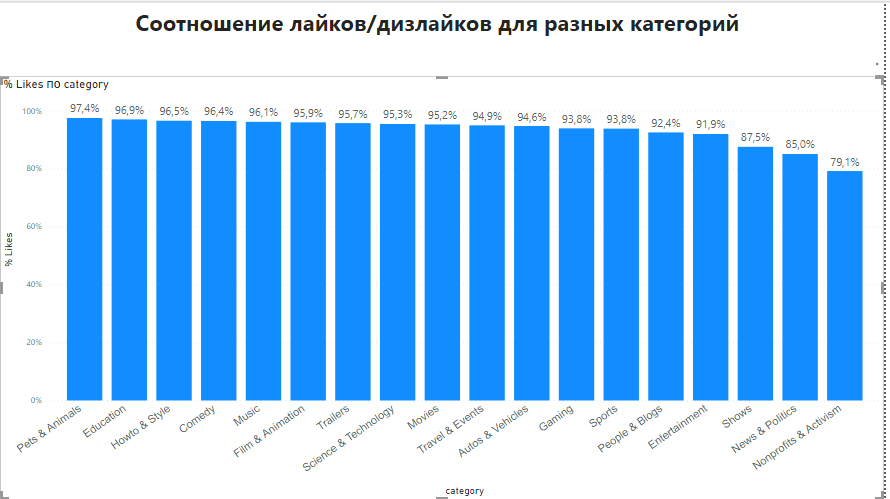

In [19]:
img = Image.open('data/pictures/no_duplicates/likes_dislikes_by_category.png')
img

### 3.6 What are the most viewed categories on YouTube?
<a id="3.6"></a>

We can see that the most viewed categories on YouTube are "Music" and "Entertainment". These categories account for 28% + 27% = 55% of all videos that are recommended.
Specifically, the category "Music" has collected 18.3 billion views, the category "Entertainment" has collected 17.7 billion views. In total, the videos that hit the trends collected 64 billion views.

In [36]:
query = """
SELECT *
    , sum(y2.total_views_by_category) OVER () as total_views
    , y2.total_views_by_category * 100 / sum(y2.total_views_by_category) OVER () as views_percentage
FROM (
    SELECT y1.category, sum(y1.max_views_per_video) as total_views_by_category
    FROM (
        SELECT
            y.video_id
            , y.category
            , max(y.views) as max_views_per_video
        FROM youtube y
        GROUP BY y.video_id) y1
    GROUP BY y1.category
    ORDER BY sum(y1.max_views_per_video) DESC) y2
"""

total_views_by_category = pd.read_sql_query(query, engine)
total_views_by_category

category  total_views_by_category  total_views  \
0                   Music              18319705979  64257131686   
1           Entertainment              17742226512  64257131686   
2          People & Blogs               5639364484  64257131686   
3                  Comedy               4598495550  64257131686   
4                  Sports               4078179896  64257131686   
5         News & Politics               3499480945  64257131686   
6        Film & Animation               3211177859  64257131686   
7           Howto & Style               2224164889  64257131686   
8                  Gaming               1428125934  64257131686   
9    Science & Technology               1283215664  64257131686   
10       Autos & Vehicles                664790876  64257131686   
11              Education                591427952  64257131686   
12         Pets & Animals                363502591  64257131686   
13  Nonprofits & Activism                271478059  64257131686   
14        Travel & Events                180763360  64257131686   
15                  Shows                152938818  64257131686   
16                 Movies                  8053865  64257131686   
17               Trailers                    38453  64257131686   

    views_percentage  
0                 28  
1                 27  
2                  8  
3                  7  
4                  6  
5                  5  
6                  4  
7                  3  
8                  2  
9                  1  
10                 1  
11                 0  
12                 0  
13                 0  
14                 0  
15                 0  
16                 0  
17                 0

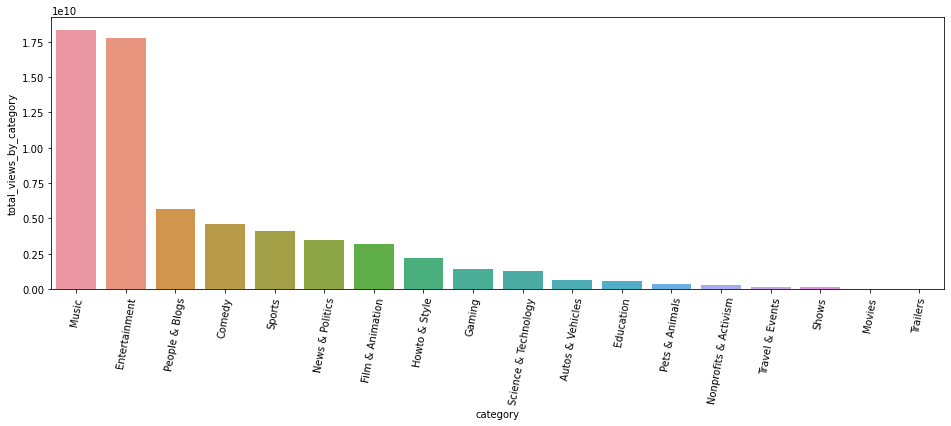

In [35]:
plt.figure(figsize=(16, 5))
g = sns.barplot(x='category', y='total_views_by_category', data=total_views_by_category)
g.set_xticklabels(g.get_xticklabels(), rotation=80);

### 3.7 How many views do videos get relative to each category by median?
<a id="3.7"></a>

Since in the dataset the same video is mostly kept in trends for several days, in order to see how much on average (more precisely by the median) each video gains relative to the categories, we group the videos, indicating the maximum number of views as an aggregating function.

In [41]:
query = """
SELECT 
    y.video_id
    , y.category
    , y.Country
    , max(y.views) as views
FROM youtube y
GROUP BY y.video_id
"""

max_views_per_video_id = pd.read_sql_query(query, engine)
max_views_per_video_id

video_id              category Country   views
0       --1skHapGUc         Entertainment  Mexico   30914
1       --2K8l6BWfw        Pets & Animals  France    4822
2       --45ws7CEN0                Gaming  Canada  309197
3       --6vcer7XYQ         Entertainment  Mexico  414012
4       --728h8mnDY         Howto & Style  France   39535
...             ...                   ...     ...     ...
185787  zzuI1sona1M        People & Blogs  Russia  561824
185788  zzvWC_pDiIk        People & Blogs  Russia   20389
185789  zzxLG6R5cHI  Science & Technology  Mexico   62134
185790  zzyGHbhCpV4       News & Politics   Japan    9760
185791  zzz0_5fMnI8       News & Politics  France   19190

[185792 rows x 4 columns]

If we look at views per 1 video in terms of the median, it turns out that according to the median, the categories "Show", "Comedy" and "Music" gain the largest number of views - 205,000, 166,000 and 145,000 views, respectively.
The lowest number of views per 1 video by median is gained by such categories as "Films", "Non-profit organizations and activism" and "Trailers" - 30,000, 27,500 and 10,000 views, respectively.

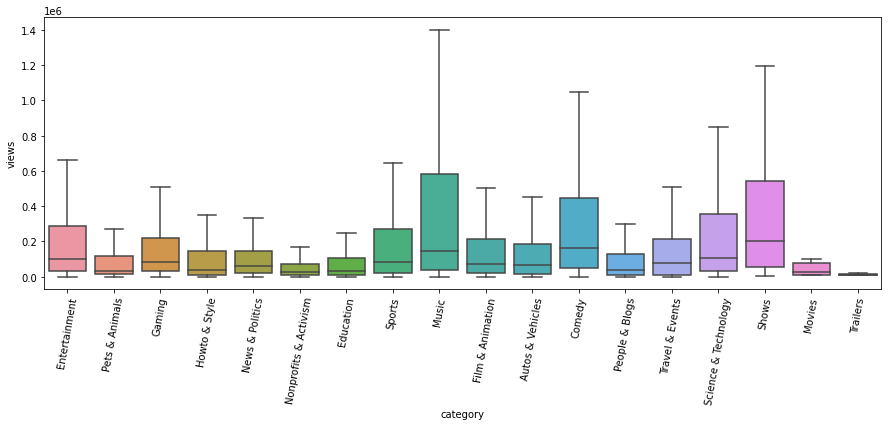

In [45]:
# No outliers
plt.figure(figsize=(15, 5))
g = sns.boxplot(x='category', y='views', data=max_views_per_video_id, showfliers=False)
g.set_xticklabels(g.get_xticklabels(), rotation=80);

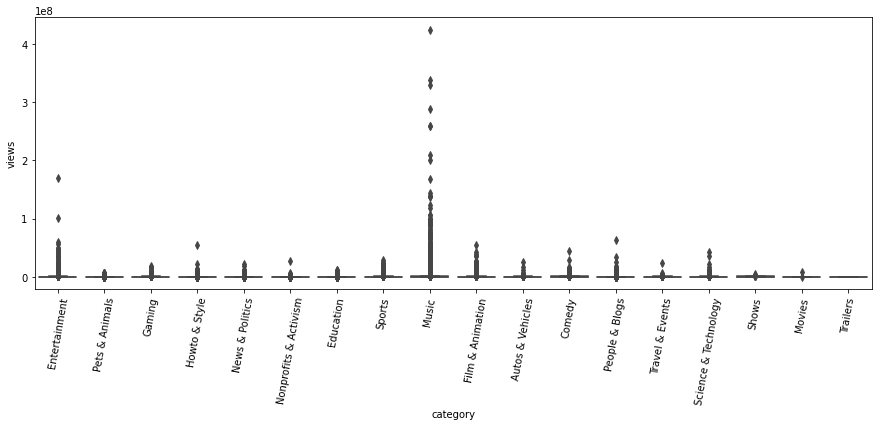

In [43]:
# With outliers
plt.figure(figsize=(15, 5))
g = sns.boxplot(x='category', y='views', data=max_views_per_video_id)
g.set_xticklabels(g.get_xticklabels(), rotation=80);

Median in tabular form

In [47]:
max_views_per_video_id.groupby('category', as_index=False).agg({'views': np.median}) \
    .sort_values('views', ascending=False)

category     views
14                  Shows  204277.0
1                  Comedy  165739.0
8                   Music  145068.0
13   Science & Technology  107875.0
3           Entertainment  101522.0
5                  Gaming   84119.0
15                 Sports   83510.0
17        Travel & Events   75513.0
4        Film & Animation   70707.0
0        Autos & Vehicles   68402.0
9         News & Politics   60025.0
11         People & Blogs   39101.0
6           Howto & Style   36690.5
12         Pets & Animals   34659.0
2               Education   30932.0
7                  Movies   29556.0
10  Nonprofits & Activism   27185.0
16               Trailers    9804.0

### 3.8 Seasonality of trends in Britain.
<a id="3.8"></a>

I noticed some seasonality, or perhaps some local events that change the nature of consumption content slightly relative to trends, if broken down by country. Britain is knocked out from the general list of countries.

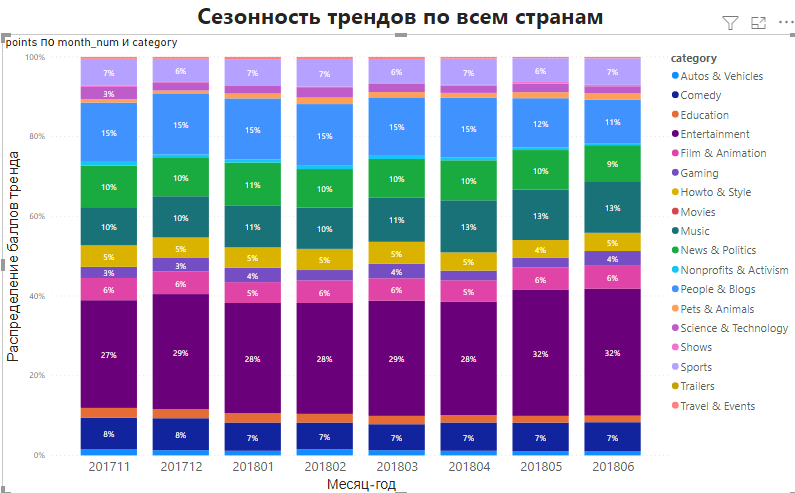

In [50]:
img = Image.open('data/pictures/seasonality_overall.png')
img

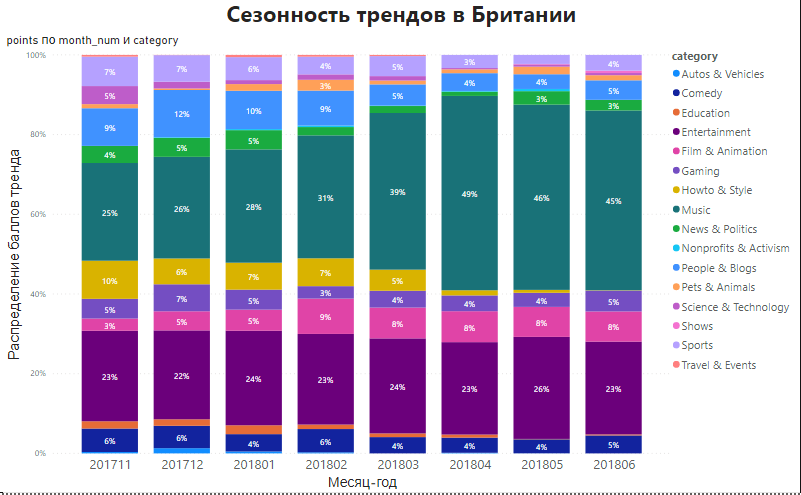

In [51]:
img = Image.open('data/pictures/seasonality_in_britain.png')
img

### 3.8.1 Why did the "Music" category start growing in the UK trends? put forward a hypothesis
<a id="3.8.1"></a>

We can see that the categories were initially distributed in a certain way and fell into trends more or less stably until March 2018. And since March 2018, "Music" began to crowd out other categories.

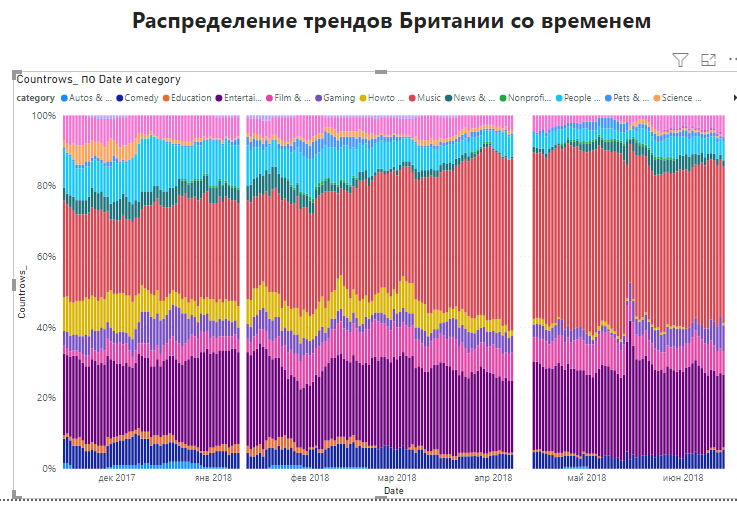

In [52]:
img = Image.open('data/pictures/stage_2/time_series_trends_britain.png')
img

The same chart in tabular form

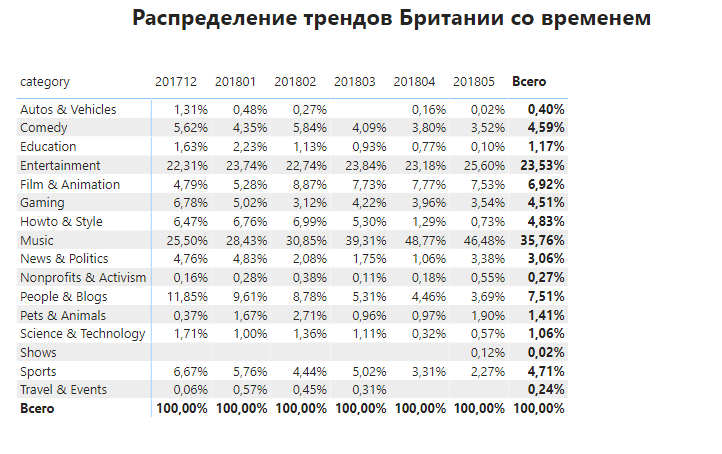

In [53]:
img = Image.open('data/pictures/stage_2/time_series_trends_britain_table_month.png')
img

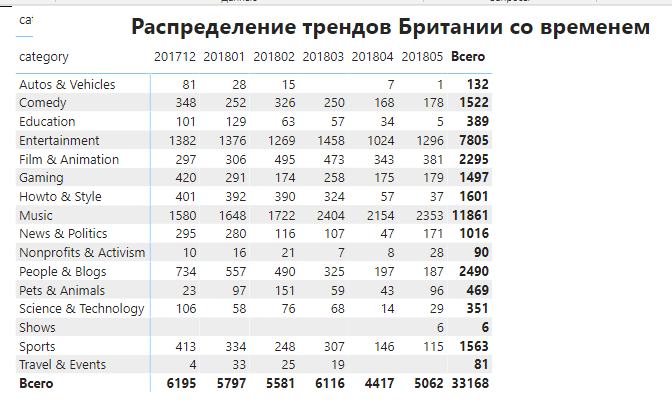

In [54]:
img = Image.open('data/pictures/stage_2/time_series_trends_britain_table_month_abs.png')
img

We can see that the average number of places occupied by music rises sharply at the end of March-April 2018 from 51 to 97. As we will see below, the reason for this will be the sharply increased retention in the trends of videos with the category "Music". That is, the music category has become more interesting to users than other categories.
The adjustment factor was introduced in order to compensate for the total number of quotas per day for Britain. Because, as you can see in the past charts, the number of quotas per day given out by YouTube to Britain dropped sharply to 170 after March 2018 (if this is not a bot bug when parsing). Other countries are stable in terms of quotas.

Now let's see what music festivals were held in the USA at that time:
Ultra Music Festival (UMF) is an annual electronic dance music festival held in March in Miami, Florida, USA. It is one of the largest festivals in the world.
In 2018, it was held from 23 to 25 March 2018.
The annual number of participants is 150,000 people.
Britain is the music capital of the world. And the center of musical tourism.

Also, the largest festivals are held in the spring in the US and in the summer in Britain. Perhaps this tradition is facilitated by the climatic features of these 2 regions. Since the USA is much closer to the Equator than Britain, the heat comes there first. Festivals are an event that takes place outdoors, so there should be a comfortable temperature - not cold and not hot.

Let's take March - the average temperature in Texas is about +18 degrees. At the same time in Britain - about +8 degrees. +8 - it's pretty cool to hold festivals outside.

And in June - the most comfortable - in Britain to hold festivals, since the temperature there is +18, and in Texas - +28 with a maximum of +30. Which is already hot considering it's the temperature in the shade. And in the sun - all +40, +45. And Miami, Florida is even hotter.

**So it is likely that the start of the music season is set by the US in the spring. And Britain picks up in the summer.
This is the reason for the deviation in trends towards music **

**That is, there is a correlation between the frequency of festivals and the average air temperature in this region.**

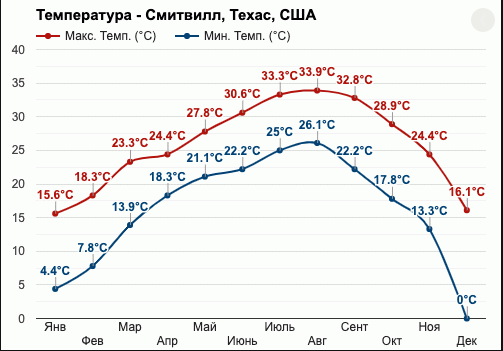

In [55]:
img = Image.open('data/pictures/stage_2/temperature_texas.png')
img

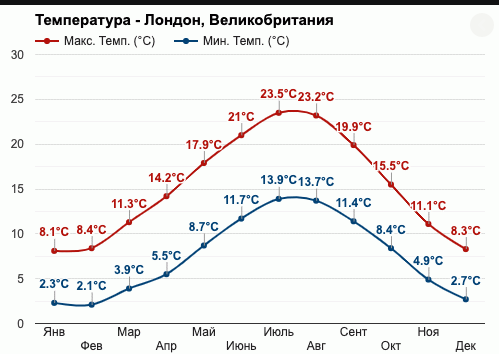

In [56]:
img = Image.open('data/pictures/stage_2/temperature_london.png')
img

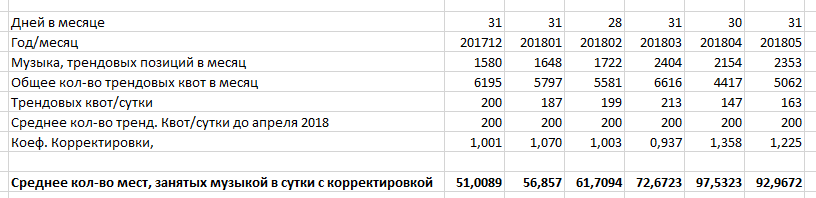

In [57]:
img = Image.open('data/pictures/stage_2/time_series_trends_britain_table_excel.png')
img

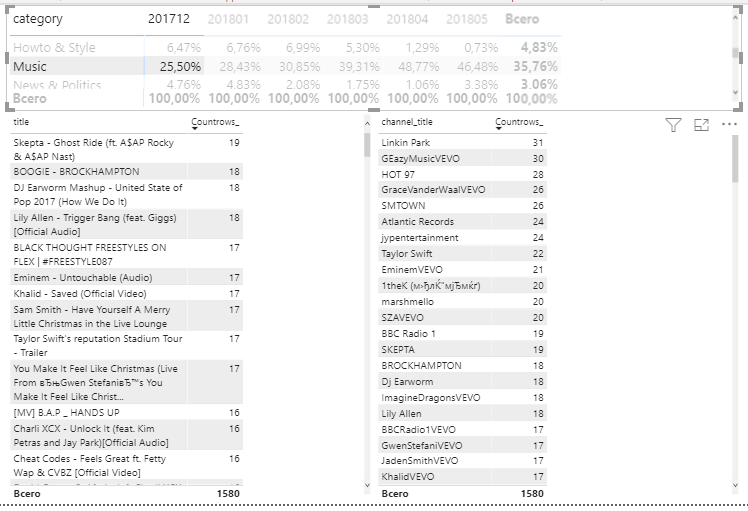

In [58]:
img = Image.open('data/pictures/stage_2/britain_music_trends_201712.png')
img

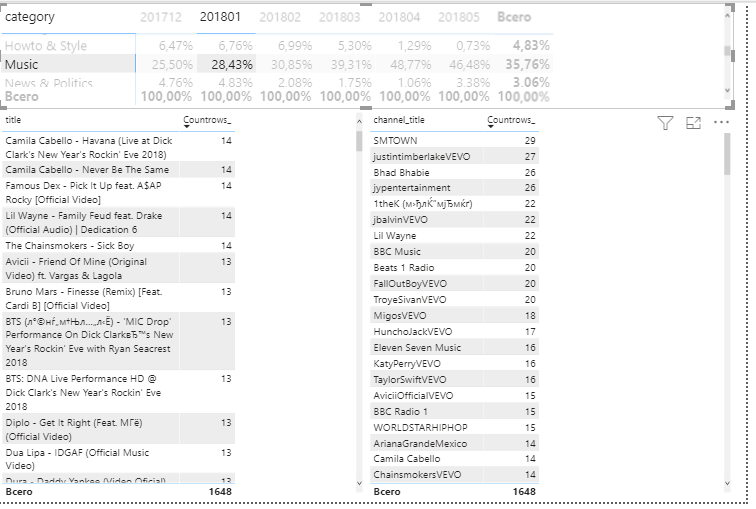

In [59]:
img = Image.open('data/pictures/stage_2/britain_music_trends_201801.png')
img

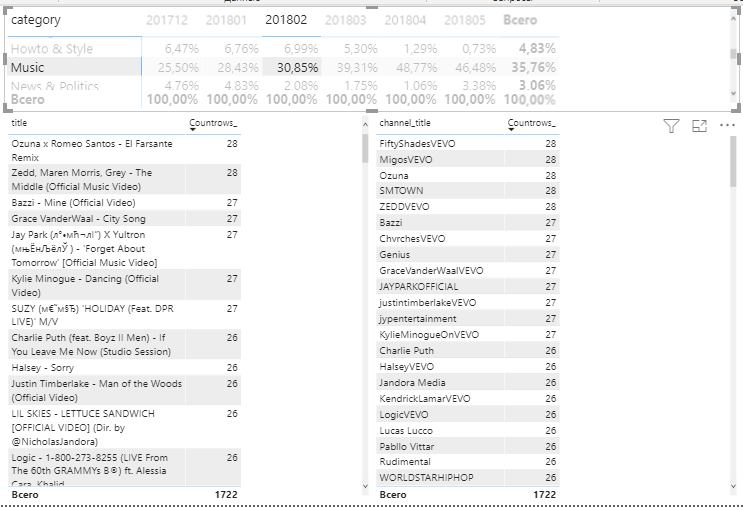

In [60]:
img = Image.open('data/pictures/stage_2/britain_music_trends_201802.png')
img

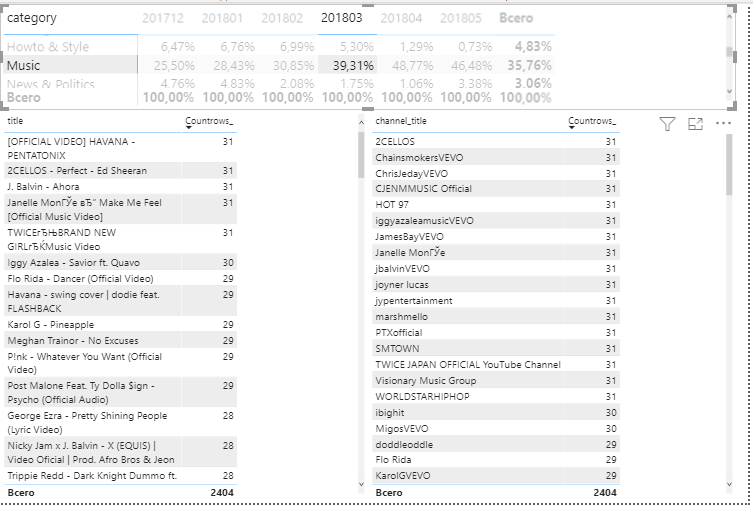

In [61]:
img = Image.open('data/pictures/stage_2/britain_music_trends_201803.png')
img

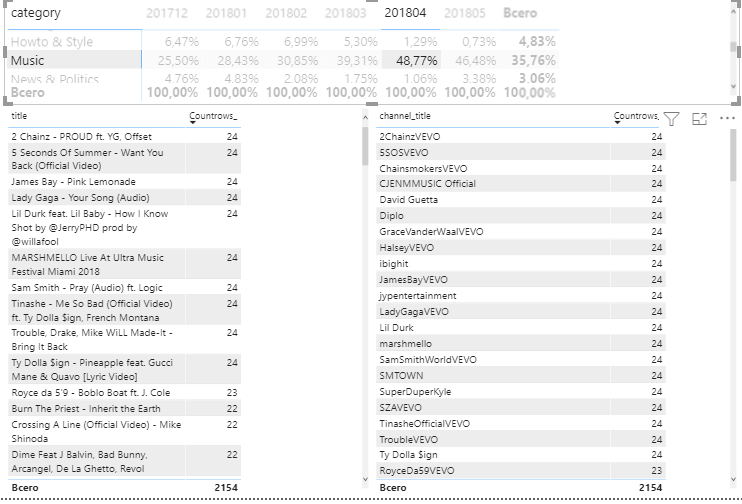

In [62]:
img = Image.open('data/pictures/stage_2/britain_music_trends_201804.png')
img

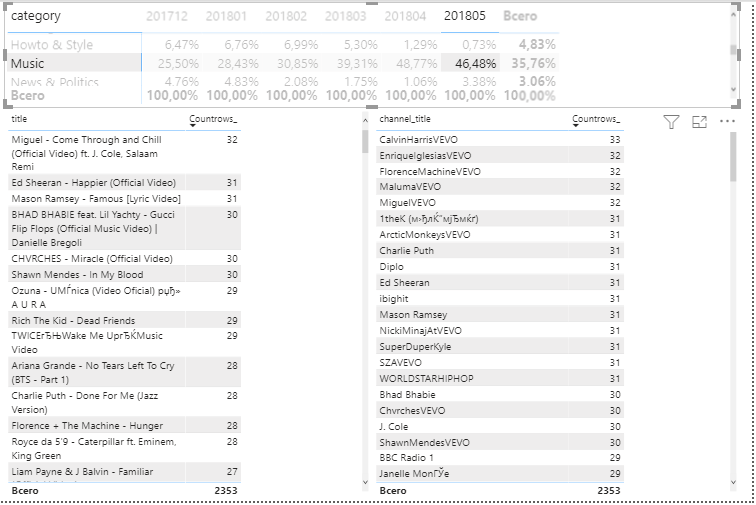

In [63]:
img = Image.open('data/pictures/stage_2/britain_music_trends_201805.png')
img

As we can see, judging by specific videos and channels, since March-April 2018, music videos have taken over trends. The number of times a particular music video is trending for almost 30 consecutive days has increased.

### 3.9 Youtube daily quotas for trends for countries
<a id="3.9"></a>

We see that the daily number of trends for all countries is stable. And it averages - 1800 / 10 countries = 180 video quotas per country per day. Racing in quotas on 02/07/2018 - it began to collect data for Japan. We see that as soon as we "connected" Japan to the base, our schedule increased in steps and stabilized. At the same time, the daily number of quotas for 1 country slightly decreased to 1900 / 11 = 173 quotas / day.

We also see that in the period from 01/09/2018 to 01/12/2018 and from 04/07/2018 to 04/14/2018, we completely lack data on trends. Perhaps for some technical reason (for example, Youtube changed the structure of the site a bit...) the bot that collected data broke down, and the bot author did not immediately notice the malfunction. But this has absolutely no effect on our analysis, since the gaps are minor.

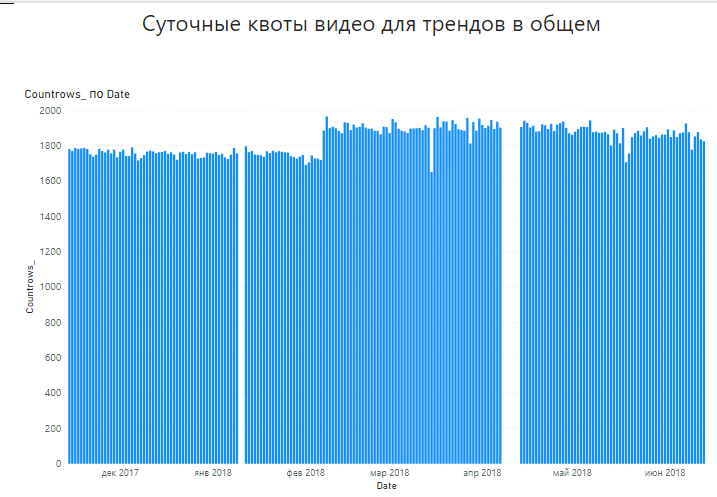

In [5]:
img = Image.open('data/pictures/stage_2/daily_YT_quotes_overall.png')
img

We see that Britain’s daily quotas for trends after 04/14/2018 begin to actively fall. While other countries remain stable at the level of 200 tons of quotas / day.

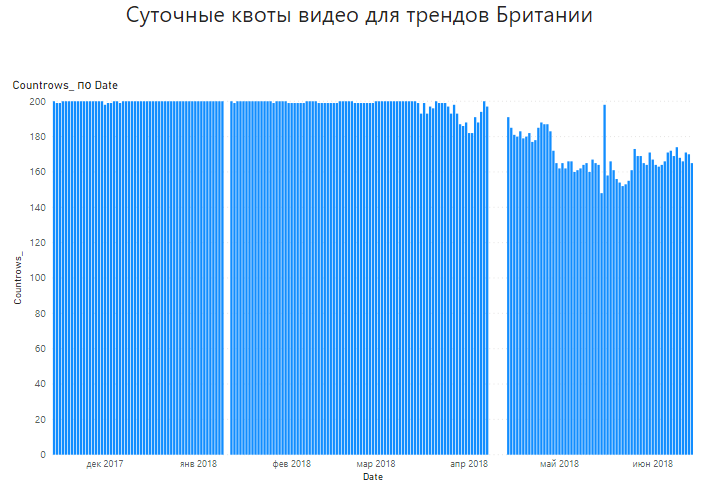

In [6]:
img = Image.open('data/pictures/stage_2/daily_YT_quotes_for_britain.png')
img

To sum it all up, the reason UK regional videos don't trend is because:

** For the UK and any other country, YouTube gives daily quotas for trends - 200 quotas / day. Once a video is trending, it stays there and prevents other videos from taking their place in the trends. The median retention in trends is 10 days for the UK, while in other countries it is 1-2 days. This is more than a significant difference**

### 3.10 How quickly do videos trend on average after release? 
<a id="3.10"></a>

In [9]:
df_unique_id_min_publish_date = df_no_duplicates.groupby('video_id').agg({'category': np.min, 'days_since_publish': np.min})

We see that in general, most categories are trending in the same way - 1 day - and the video is already trending. The exception is the "Trailers" category, where it enters trends on average 4 days after publication.

** From here we can draw the following conclusion - THE FIRST DAYS ARE DECISIVE WHETHER THE VIDEO WILL BE IN TRENDS OR NOT. User activity in the FIRST DAY after publication is DECISIVE**

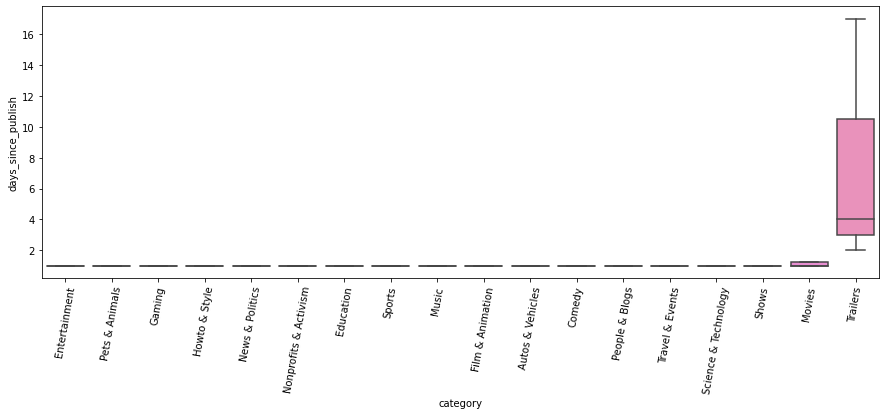

In [10]:
# Time from publication to the first entry into trends
plt.figure(figsize=(15, 5))
g = sns.boxplot(x='category', y='days_since_publish', data=df_unique_id_min_publish_date, showfliers=False);
g.set_xticklabels(g.get_xticklabels(), rotation=80);

In [11]:
df_unique_id_min_publish_date.groupby('category').agg({'days_since_publish': np.median})

days_since_publish
category                                 
Autos & Vehicles                        1
Comedy                                  1
Education                               1
Entertainment                           1
Film & Animation                        1
Gaming                                  1
Howto & Style                           1
Movies                                  1
Music                                   1
News & Politics                         1
Nonprofits & Activism                   1
People & Blogs                          1
Pets & Animals                          1
Science & Technology                    1
Shows                                   1
Sports                                  1
Trailers                                4
Travel & Events                         1

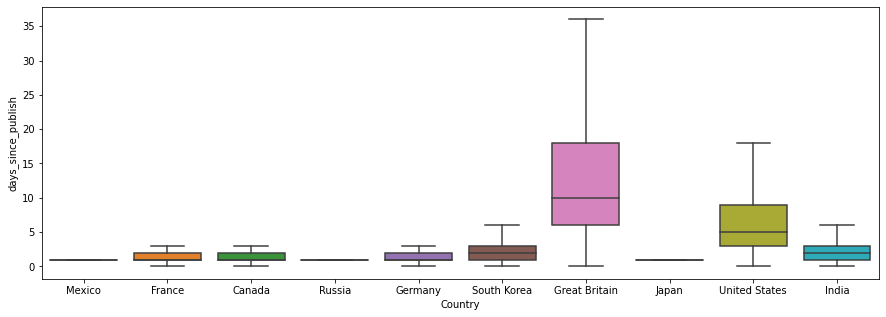

In [28]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='Country', y='days_since_publish', data=df_no_duplicates, showfliers=False);

### 3.11 Why is the same video trending in the UK twice as long as it is trending in the US?
<a id="3.11"></a>

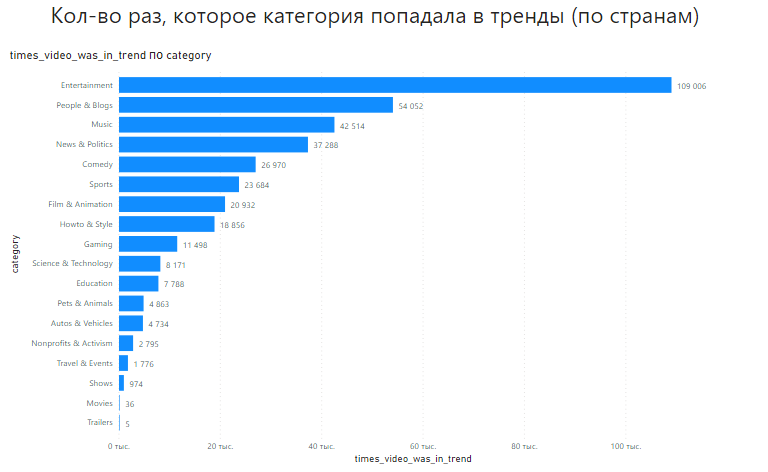

In [29]:
img = Image.open('data/pictures/stage_2/times_category_was_in_trend.png')
img

What do all these videos have in common? All these videos are combined in English and the country of origin is the USA. Marvel Studio, Paramount, Taylor Swift, Maroon 5... are all US companies and artists.
Only Ed Sheeran is an English singer.
**Competition between the US and England.** The US is more competitive in terms of content and is crowding out the locals due to the fact that both the Americans and the British speak English.

Also, one more observation - the number of days that each video was in trend in each country differs by about 1.5-2 times. For example, the Maroon 5 - Wait video lasted 40 days in England and 18 days in the US. That is, the same video is 2 TIMES EASIER to stay in the trends of England than in the trends of the USA. Considering that for the USA and England, YouTube issues 200 quotas per day. This means that US imports are crowding out British "local producers". Also, content from the US is popular in India and Canada and often quite often takes trend quotas there.
This also means that competition in the US market is twice as tough as in the UK market. Because after 18 days in the US, the video went out of trend and some other video took its place. While it still continues to hang in the trends of Britain.

It also means that content from the US is more appealing to the British viewer than content from the UK Producer.

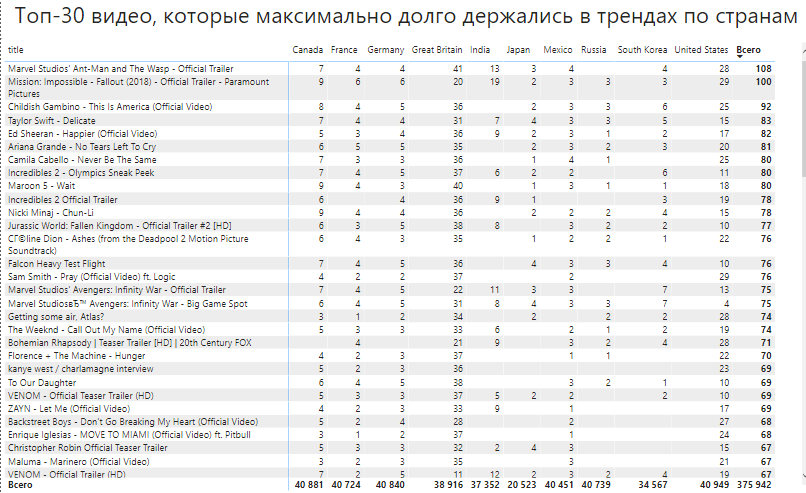

In [30]:
img = Image.open('data/pictures/stage_2/times_video_was_in_trend.png')
img

### 3.12 Find news stories that influenced YouTube trends
<a id="3.12"></a>

In order to answer this question - let's go the following way - these are outliers in the data on the 'days_since_publish' column. In other words - we will find videos that shot (hit trends) more than 3 years after publication

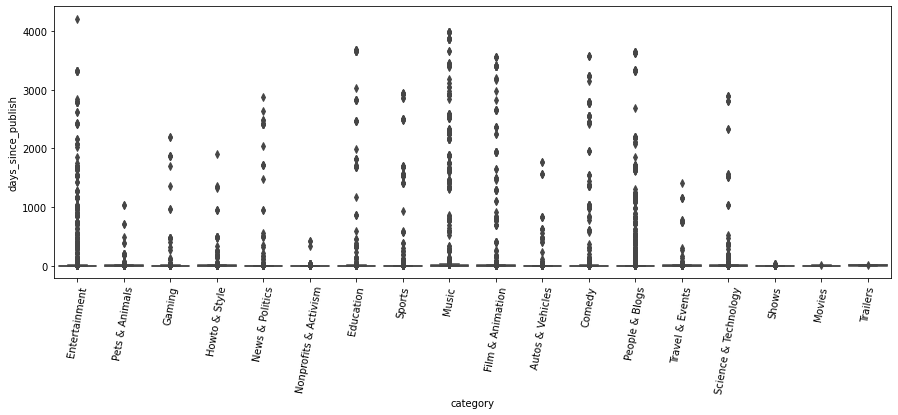

In [33]:
plt.figure(figsize=(15, 5))
g = sns.boxplot(x='category', y='days_since_publish', data=df_no_duplicates)
g.set_xticklabels(g.get_xticklabels(), rotation=80);

We see that there are 154 such unique records.

In [38]:
query = """
    SELECT count(DISTINCT video_id) AS videos_in_trends_after_1_year_since_publish
    FROM youtube
    WHERE days_since_publish > 1000
"""
pd.read_sql_query(query, engine)

videos_in_trends_after_1_year_since_publish
0                                          154

In [39]:
df_trending_after_1000_days = df_no_duplicates[df_no_duplicates['days_since_publish'] > 1000].groupby('video_id') \
                                        .agg({'video_id': np.max, 'trending_date': np.min, 
                                              'title': np.max, 'channel_title': np.max, 'tags': np.max,
                                             'views': np.min, 'likes': np.min, 'dislikes': np.min, 'comment_count': np.min,
                                             'description': np.max, 'category': np.max, 'publish_date_no_tz': np.min,
                                             'Country': np.max, 'days_since_publish':np.min})

In [40]:
df_trending_after_1000_days.sort_values('views', ascending=False).head(50)

video_id        trending_date  \
video_id                                        
qu-biRtYEcU  qu-biRtYEcU  2017-11-26 00:00:00   
7nKZt8uz9ZM  7nKZt8uz9ZM  2018-01-16 00:00:00   
moe3i3AycwE  moe3i3AycwE  2017-12-15 00:00:00   
8HON4AswPVk  8HON4AswPVk  2017-11-14 00:00:00   
36sO84Hq6kw  36sO84Hq6kw  2017-11-21 00:00:00   
QJ7vgnWARNA  QJ7vgnWARNA  2018-01-16 00:00:00   
DfYRIN3U3SU  DfYRIN3U3SU  2018-01-02 00:00:00   
zzjNCiCqiOs  zzjNCiCqiOs  2017-12-26 00:00:00   
uheJQjs2nQY  uheJQjs2nQY  2017-12-27 00:00:00   
hTSAyR3nOR0  hTSAyR3nOR0  2018-01-17 00:00:00   
d8RW-WSpAhQ  d8RW-WSpAhQ  2017-11-14 00:00:00   
P_37AVnrqG0  P_37AVnrqG0  2018-01-16 00:00:00   
TosJRlDgKCA  TosJRlDgKCA  2018-01-17 00:00:00   
lT47mzF3QVM  lT47mzF3QVM  2017-11-14 00:00:00   
JZYR2n5IWAc  JZYR2n5IWAc  2017-11-29 00:00:00   
K7NE3nfdkgg  K7NE3nfdkgg  2017-12-02 00:00:00   
MJO3FmmFuh4  MJO3FmmFuh4  2018-02-05 00:00:00   
rrkW65P-5sc  rrkW65P-5sc  2017-12-04 00:00:00   
qxXZF60EPdM  qxXZF60EPdM  2018-01-25 00:00:00   
moLKl5PzZLc  moLKl5PzZLc  2017-11-16 00:00:00   
4diqg8_3a-0  4diqg8_3a-0  2018-02-05 00:00:00   
NXNM0dTzHOE  NXNM0dTzHOE  2018-01-06 00:00:00   
iLN0_ghe-Tc  iLN0_ghe-Tc  2017-11-29 00:00:00   
76c_nxhuVdM  76c_nxhuVdM  2018-01-17 00:00:00   
dqkEniTFTH0  dqkEniTFTH0  2017-12-19 00:00:00   
j5AILysDDTI  j5AILysDDTI  2017-11-14 00:00:00   
_OkxKKsL2u8  _OkxKKsL2u8  2018-01-01 00:00:00   
Upems4CB_ps  Upems4CB_ps  2017-11-30 00:00:00   
i_DA2Uze6GM  i_DA2Uze6GM  2017-11-20 00:00:00   
tYFYoLEO0dM  tYFYoLEO0dM  2018-01-18 00:00:00   
6A3cHzFQsqI  6A3cHzFQsqI  2018-01-25 00:00:00   
L1fwxUV6GJE  L1fwxUV6GJE  2017-11-14 00:00:00   
EDyun420L3E  EDyun420L3E  2018-01-16 00:00:00   
4qOeuzeNfQ8  4qOeuzeNfQ8  2018-01-27 00:00:00   
45L82cOjfY0  45L82cOjfY0  2018-02-06 00:00:00   
SV2sPlDLQtU  SV2sPlDLQtU  2017-12-27 00:00:00   
vd4zwINEcLY  vd4zwINEcLY  2017-11-14 00:00:00   
qC0I5PEhkJo  qC0I5PEhkJo  2017-11-15 00:00:00   
Q_VeGFPY6BM  Q_VeGFPY6BM  2018-02-25 00:00:00   
e_LpxldL8h4  e_LpxldL8h4  2017-12-29 00:00:00   
9Rl8U6v6__4  9Rl8U6v6__4  2017-12-03 00:00:00   
GC4gnq94kZE  GC4gnq94kZE  2018-01-08 00:00:00   
gO_QM9oUcM0  gO_QM9oUcM0  2017-11-27 00:00:00   
wFEAoF7RC7Y  wFEAoF7RC7Y  2017-11-25 00:00:00   
rtQXLmkeOgo  rtQXLmkeOgo  2017-12-12 00:00:00   
p9zTSvEpt_8  p9zTSvEpt_8  2018-01-25 00:00:00   
tP_Dk81f9fg  tP_Dk81f9fg  2018-01-28 00:00:00   
d8HKnWncwks  d8HKnWncwks  2017-12-22 00:00:00   
iwd9apG72IE  iwd9apG72IE  2018-01-16 00:00:00   
K9kVsnTQh-g  K9kVsnTQh-g  2018-01-25 00:00:00   

                                                         title  \
video_id                                                         
qu-biRtYEcU                                Volar - Jaime Ciero   
7nKZt8uz9ZM                Zombie - Cranberries  MTV Unplugged   
moe3i3AycwE  Frida | 'Dancing Around An Issue' (HD) - Salma...   
8HON4AswPVk                            Arvo Pärt - Tabula Rasa   
36sO84Hq6kw  Imperial Anthem of the Ottoman Empire - Mecidi...   
QJ7vgnWARNA               Dolores O'Riordan - When You're Gone   
DfYRIN3U3SU                        November Rain Guns N' Roses   
zzjNCiCqiOs                                      the hell hole   
uheJQjs2nQY  The Mathany Green House Project - Dropping a G...   
hTSAyR3nOR0            Dolores O'riordan - her house in Canada   
d8RW-WSpAhQ  Weed Killer Challenge: Vinegar 'Weed B Gone' v...   
P_37AVnrqG0                The Cranberries -  No Need to Argue   
TosJRlDgKCA                          The Best of Keith Jackson   
lT47mzF3QVM  Grey's Anatomy - (It's the End of the World) -...   
JZYR2n5IWAc  Arctic Monkeys - Cornerstone (Live Session for...   
K7NE3nfdkgg                                  Creepy Matt lauer   
MJO3FmmFuh4                   Budweiser - Original Whazzup? ad   
rrkW65P-5sc                                            DAY MAN   
qxXZF60EPdM               Hugh Masekela - Grazing In The Grass   
moLKl5PzZLc  Benton Fenton is missing - Hitler finds out! J...   
4diqg8_3a-0    

### 3.12.1 Crannberies lead singer Dolores Mary Eileen O'Riordan dies
<a id="3.12.1"></a>

Attention was drawn to the video **Zombie - Cranberries MTV Unplugged**. We are looking for the group Crannberies in the news and we see that the soloist of Dolores Mary Eileen O'Riordan died on 01/15/2018 in London. People started searching for her most famous song Zombies on YouTube. As a result, it turned out to be in trends.

In [43]:
df_trending_after_1000_days[df_trending_after_1000_days['video_id'] == '7nKZt8uz9ZM']

video_id        trending_date  \
video_id                                        
7nKZt8uz9ZM  7nKZt8uz9ZM  2018-01-16 00:00:00   

                                           title    channel_title  \
video_id                                                            
7nKZt8uz9ZM  Zombie - Cranberries  MTV Unplugged  CranberriesVEVO   

                                                          tags    views  \
video_id                                                                  
7nKZt8uz9ZM  MTV Unplugged (TV Program)|"The Cranberries (M...  1174711   

             likes  dislikes  comment_count  \
video_id                                      
7nKZt8uz9ZM   5859        82            535   

                                                   description       category  \
video_id                                                                        
7nKZt8uz9ZM  Zombie Live Taratata:https://www.youtube.com/w...  Entertainment   

              publish_date_no_tz Country  days_since_publish  
video_id                                                      
7nKZt8uz9ZM  2013-07-31 00:00:00  Canada                1630

Where did it stay in the Canadian trends for 2 days.

In [44]:
df_no_duplicates[df_no_duplicates['video_id'] == '7nKZt8uz9ZM']

video_id        trending_date                                title  \
47929  7nKZt8uz9ZM  2018-01-16 00:00:00  Zombie - Cranberries  MTV Unplugged   
47930  7nKZt8uz9ZM  2018-01-17 00:00:00  Zombie - Cranberries  MTV Unplugged   

         channel_title                                               tags  \
47929  CranberriesVEVO  MTV Unplugged (TV Program)|"The Cranberries (M...   
47930  CranberriesVEVO  MTV Unplugged (TV Program)|"The Cranberries (M...   

         views  likes  dislikes  comment_count  \
47929  1174711   5859        82            535   
47930  1250500   6290        84            586   

                                       thumbnail_link  ...  ratings_disabled  \
47929  https://i.ytimg.com/vi/7nKZt8uz9ZM/default.jpg  ...                 0   
47930  https://i.ytimg.com/vi/7nKZt8uz9ZM/default.jpg  ...                 0   

       video_error_or_removed  \
47929                       0   
47930                       0   

                                             description       category  \
47929  Zombie Live Taratata:https://www.youtube.com/w...  Entertainment   
47930  Zombie Live Taratata:https://www.youtube.com/w...  Entertainment   

        publish_time_no_tz   publish_date_no_tz Country points  \
47929  2013-07-31 18:33:42  2013-07-31 00:00:00  Canada      1   
47930  2013-07-31 18:33:42  2013-07-31 00:00:00  Canada      1   

       Year_month_int  days_since_publish  
47929          201801                1630  
47930          201801                1631  

[2 rows x 21 columns]

Let's see how many video matches have the keyword "Dolores" or "Cranberries"

We see 33 videos, which, the main date of which is 01/16/2018

In [45]:
query = """
    SELECT *
    FROM youtube
    WHERE title LIKE '%Dolores%' OR title LIKE '%Cranberries%'
    GROUP BY video_id
"""
dolores_death = pd.read_sql_query(query, engine)
dolores_death

video_id        trending_date  \
0   0nVO-yU0oxM  2018-01-16 00:00:00   
1   3hn14sIQc6E  2018-01-16 00:00:00   
2   5m3jbprryEM  2018-05-17 00:00:00   
3   5mMjpJ6vR_o  2018-01-16 00:00:00   
4   5rUfyUN7veY  2018-01-17 00:00:00   
5   7nKZt8uz9ZM  2018-01-16 00:00:00   
6   A7PZNHUlQi8  2018-01-16 00:00:00   
7   AufR4Ajod5U  2018-01-17 00:00:00   
8   EDyun420L3E  2018-01-16 00:00:00   
9   FFup6eiG0f0  2018-01-16 00:00:00   
10  IP9btlfEk-8  2018-01-13 00:00:00   
11  P_37AVnrqG0  2018-01-16 00:00:00   
12  Q7KfJ5HMghw  2018-01-16 00:00:00   
13  QJ7vgnWARNA  2018-01-16 00:00:00   
14  QwglwQlVSEg  2018-01-16 00:00:00   
15  RkzGWTpeeEI  2018-01-16 00:00:00   
16  VoA-UVMIOzs  2018-01-16 00:00:00   
17  Wer2JDtSA1s  2018-01-16 00:00:00   
18  Xar6AFEYpZg  2018-01-16 00:00:00   
19  YekGSAOyLng  2018-01-16 00:00:00   
20  Yf5ArkLMVCM  2018-01-16 00:00:00   
21  YrcVsF0QvaM  2018-01-17 00:00:00   
22  ZHkVdeQl21E  2018-01-23 00:00:00   
23  ZpNABHY1f8I  2017-11-29 00:00:00   
24  gMPzi1ethAk  2018-01-17 00:00:00   
25  hTSAyR3nOR0  2018-01-17 00:00:00   
26  ia_NWRMgoAA  2018-01-20 00:00:00   
27  jwADOxzjfsQ  2018-01-16 00:00:00   
28  k0HUiU_qSac  2018-03-06 00:00:00   
29  lRAGdJoCuzc  2018-01-16 00:00:00   
30  sSnHRLLy3p0  2018-01-16 00:00:00   
31  tYFYoLEO0dM  2018-01-18 00:00:00   
32  tm6Edi3lZIA  2018-01-16 00:00:00   
33  wl1CAr2PERE  2018-01-16 00:00:00   
34  xLheVndnabg  2018-01-16 00:00:00   
35  ypcO0KWJZyU  2018-02-08 00:00:00   

                                                title  \
0     Cranberries singer Dolores O'Riordan dead at 46   
1   Dolores O'Riordan, The Cranberries singer, dea...   
2   Elena Farga se sienta en una silla al ritmo de...   
3   Dolores O'Riordan, la chanteuse des Cranberrie...   
4    The Cranberries - Stars (The Best Of 1992-2002 )   
5                 Zombie - Cranberries  MTV Unplugged   
6   Fallece Dolores O'Riordan Muere vocalista de T...   
7           The Cranberries - Zombie (R.I.P. Dolores)   
8                            Dolores habla en español   
9   Muere repentinamente a los 46 años Dolores O'R...   
10  Bebe una cuchara al día y nunca tendrá dolores...   
11                The Cranberries -  No Need to Argue   
12  La chanteuse de The Cranberries, Dolores O'Rio...   
13               Dolores O'Riordan - When You're Gone   
14          Fallece Dolores O'Riordan (ADN40)(MÉXICO)   
15               El Ultimo Tweet de Dolores O'Riordan   
16  FALLECE DOLORES O'RIORDAN MUERE VOCALISTA DE T...   
17  ADIÓS DOLORES O'RIORDAN 1971-2018 | The Cranbe...   
18  My Tribute To Dolores O'Riordan (R.I.P) 1971-2...   
19  TRENDING 15 ENERO - DIVAZA 5M, MUERE VOCALISTA...   
20  Murió Dolores O'Riordan, vocalista de The Cra...   
21         Умерла Долорес О’Риордан (The Cranberries)   
22  REVELAN la causa del Fallecimiento de Dolores ...   
23  Té para dolores de cabezas, migrañas y problem...   
24  ¿Por qué murió Dolores O'Riordan vocalista The...   
25            Dolores O'riordan - her house in Canada   
26                   How the Cranberries Rose to Fame   
27  Fallece Dolores O'Riordan, vocalista de The Cr...   
28           SIENTES ESTOS DOLORES AL TOCAR GUITARRA?   
29  Murió Dolores O'Riordan, vocalista de The Cran...   
30                 The Cranberries BBC Breakfast 2017   
31          The Cranberries - Dreams (Music Video HQ)   
32  La muerte de Dolores O'Riordan apaga una de la...   
33  Muere la vocalista de The Cranberries | Notici...   
34  The Cranberries (†) - Live 2017 @ Paris Olympi...   
35    TOP 7 DOLORES MAS FUERTE QUE TENDRAS EN TU VIDA   

                                  channel_title  \
0                                      CBC News   
1                           New York Daily News   
2                               Factor X España   
3                                       6Medias   
4                                         Lotov   
5                               CranberriesVEVO   
6                                      Tuitealo   
7       

We see that in terms of trends, this newsbreak sharply slows down already 2-3 days after death.

In [46]:
dolores_death.groupby('trending_date')[['trending_date']].count()

trending_date
trending_date                     
2017-11-29 00:00:00              1
2018-01-13 00:00:00              1
2018-01-16 00:00:00             23
2018-01-17 00:00:00              5
2018-01-18 00:00:00              1
2018-01-20 00:00:00              1
2018-01-23 00:00:00              1
2018-02-08 00:00:00              1
2018-03-06 00:00:00              1
2018-05-17 00:00:00              1

This is what the mentions for the keyword "Dolores" look like

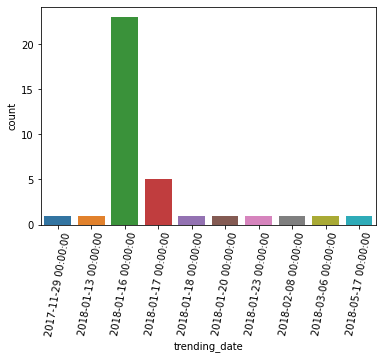

In [47]:
g = sns.countplot(x='trending_date', data=dolores_death.sort_values('trending_date'))
g.set_xticklabels(g.get_xticklabels(), rotation=80);

### 3.12.2 Newsletter about the sex scandal of actress Salma Hayek and American film producer Harvey Weinstein
<a id="3.12.2"></a>

Next, take a video that only trended 3 years after being published under the title **Frida | 'Dancing Around An Issue' (HD)** What could have contributed to this?

In [48]:
query = """
    SELECT *
    FROM youtube
    WHERE video_id LIKE 'moe3i3AycwE'
"""
pd.read_sql_query(query, engine)

video_id        trending_date  \
0  moe3i3AycwE  2017-12-15 00:00:00   

                                               title channel_title  \
0  Frida | 'Dancing Around An Issue' (HD) - Salma...       Miramax   

                                                tags   views  likes  dislikes  \
0  Trailer|"Official Trailer"|"Frida"|"Oscars"|"C...  787752   1488       135   

   comment_count                                  thumbnail_link  ...  \
0             62  https://i.ytimg.com/vi/moe3i3AycwE/default.jpg  ...   

   ratings_disabled  video_error_or_removed  \
0                 0                       0   

                                         description          category  \
0  Frida (Salma Hayek) wins a dance with Tina (As...  Film & Animation   

    publish_time_no_tz   publish_date_no_tz Country points  Year_month_int  \
0  2014-12-11 20:21:20  2014-12-11 00:00:00  Canada      1          201712   

   days_since_publish  
0                1100  

[1 rows x 21 columns]

The fact is that the main character of this video is Salma Hayek.
The trending date for this video, 12/15/2017, coincides with the date of the Harvey Weinstein sex scandal.
NYTimes publication dated 12/13/2017
https://www.nytimes.com/interactive/2017/12/13/opinion/contributors/salma-hayek-harvey-weinstein.html

Another video trended in Mexico with the keyword "Hayek" on 12/16/2017. Salma Hayek - Mexican actress

In [49]:
query = """
    SELECT video_id, trending_date, title, views, category, Country, days_since_publish
    FROM youtube
    WHERE title LIKE '%Hayek%'
    GROUP BY video_id
"""
pd.read_sql_query(query, engine)

video_id        trending_date  \
0  0ADsNDbX6XY  2017-12-16 00:00:00   
1  Oajf12wWYdQ  2018-03-05 00:00:00   
2  moe3i3AycwE  2017-12-15 00:00:00   

                                               title   views  \
0  TRENDING 15 DICIEMBRE - ZURIPONS EN DOWNTOWN, ...   69655   
1         SALMA HAYEK SE EQUIVOCA EN LOS OSCARES !!!    2361   
2  Frida | 'Dancing Around An Issue' (HD) - Salma...  787752   

           category Country  days_since_publish  
0     Entertainment  Mexico                   0  
1     Entertainment  Mexico                   0  
2  Film & Animation  Canada                1100